In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:40941")
client

<Client: 'tcp://127.0.0.1:40941' processes=8 threads=40, memory=157.39 GiB>

In [11]:
client.restart()

<Client: 'tcp://127.0.0.1:37663' processes=0 threads=0, memory=0 B>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
# from dask.diagnostics import ProgressBar
import os.path as op
import os
import gsw
import time
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from MITgcmutils import jmd95
import matplotlib
matplotlib.rcParams['pcolor.shading'] = 'auto'
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# from xlayers import finegrid, layers
# from xlayers.core import layers_numpy, layers_apply

In [4]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'
tdgs = '/tank/tdgs/tuchida/TWA/'

In [5]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -15
yNstart = 25
yend = 50

Nyears = 50

xchunk = 100
ychunk = 101
schunk = 5
membchunk = 1
dnf = 2160
nfile = 73

In [6]:
ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                             % (0,1967)), 
                     grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                     iters=1421280,
                     prefix=['diag_ocnTave'], delta_t=2e2,
                    ).sel(YC=slice(yNstart-12**-1,yend+2*12**-1),
                          YG=slice(yNstart-12**-1,yend+2*12**-1)
                         ).chunk({'XC':xchunk,'XG':xchunk,
                                  'YC':ychunk,'YG':ychunk})
ds

<xarray.Dataset>
Dimensions:  (time: 1, XC: 1000, YC: 303, XG: 1000, YG: 303, Z: 46, Zp1: 47, Zu: 46, Zl: 46)
Coordinates: (12/33)
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 3290 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 24.92 25.0 25.08 25.17 25.25 ... 49.83 49.92 50.0 50.08
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 24.96 25.04 25.13 25.21 25.29 ... 49.88 49.96 50.04 50.13
    ...       ...
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 101, 100), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 101, 100), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(101, 100), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(101, 100), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(101, 100), meta=np.ndarray>
Data variables:
    THETA    (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 101, 100), meta=np.ndarray>
    SALT     (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 101, 100), meta=np.ndarray>
    UVEL     (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 46, 101, 100), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 46, 101, 100), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 46, 101, 100), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

# Years 1963-2012

In [7]:
years = np.arange(1963,2013,dtype=int)
ntimes = np.arange(790560,8672400+dnf,dnf).reshape(len(years),nfile)
# dd = 11
yystart = 0
print(years[yystart],ntimes[yystart])

1963 [790560 792720 794880 797040 799200 801360 803520 805680 807840 810000
 812160 814320 816480 818640 820800 822960 825120 827280 829440 831600
 833760 835920 838080 840240 842400 844560 846720 848880 851040 853200
 855360 857520 859680 861840 864000 866160 868320 870480 872640 874800
 876960 879120 881280 883440 885600 887760 889920 892080 894240 896400
 898560 900720 902880 905040 907200 909360 911520 913680 915840 918000
 920160 922320 924480 926640 928800 930960 933120 935280 937440 939600
 941760 943920 946080]


In [8]:
imemb = 0
# yy = yystart

# ds5 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/dZb/ann' 
#                            % (imemb))
#                   )
ds6 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zb/ann' 
                           % (imemb))
                  )
ds9 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dynb/ann' 
                           % (imemb))
                  )
ds10 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Pb/ann' 
                            % (imemb))
                   )
ds6

/tmp/ipykernel_22561/3422258638.py:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds6 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zb/ann'
/tmp/ipykernel_22561/3422258638.py:10: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to

<xarray.Dataset>
Dimensions:       (XC: 1000, XG: 1000, YC: 303, YG: 303, delta_outer: 55, deltax_outer: 55, deltay_outer: 55, time: 73)
Coordinates:
  * XC            (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * XG            (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * YC            (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * YG            (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * delta_outer   (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * deltax_outer  (deltax_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * deltay_outer  (deltay_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
Dimensions without coordinates: time
Data variables:
    dzetab        (time, YC, XC, delta_outer) float32 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    dzetaxb       (time, YC, XG, deltax_outer) float32 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    dzetayb       (time, YG, XC, deltay_outer) float32 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    zetab         (time, YC, XC, delta_outer) float32 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    zetaxb        (time, YC, XG, deltax_outer) float32 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    zetayb        (time, YG, XC, deltay_outer) float32 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>

In [8]:
ds10.mbxb.isel(time=0,deltax_outer=23).plot()

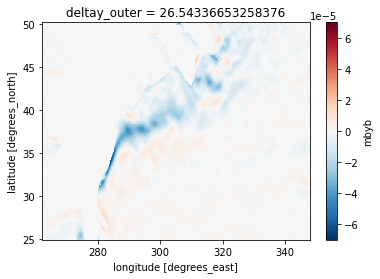

In [17]:
ds10.mbyb.isel(time=0,deltay_outer=23).plot()

In [25]:
dyy = 10
n10 = 0
yy = int(n10*dyy)
imemb = 0

for year in years[int(n10*dyy):]:
    
    if yy % dyy == 0:
        ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                   % (imemb,year))
                          ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')
        ds7 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zps/ann/run%4d/' 
                                   % (imemb,year))
                          ).chunk({'XC':xchunk,'XG':xchunk}
                                                   ).drop_vars('time')
        ds8 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dynps/ann/run%4d/' 
                                       % (imemb,year))
                              ).chunk({'XC':xchunk,'XG':xchunk}
                                                   ).drop_vars('time')
        ds11 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Pps/ann/run%4d/' 
                                        % (imemb,year))
                               ).chunk({'XC':xchunk,'XG':xchunk}
                                                    ).drop_vars('time')
    else:
        tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                    % (imemb,year))
                           ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')

        ds2 = xr.concat([ds2,tmp2], 'Nyr')
        tmp2.close()
        tmp7 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zps/ann/run%4d/' 
                                    % (imemb,year))
                            ).chunk({'XC':xchunk,'XG':xchunk}
                                                    ).drop_vars('time')
        ds7 = xr.concat([ds7,tmp7], 'Nyr')
        tmp7.close()
        tmp8 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dynps/ann/run%4d/' 
                                    % (imemb,year))
                           ).chunk({'XC':xchunk,'XG':xchunk}
                                                    ).drop_vars('time')
        ds8 = xr.concat([ds8,tmp8], 'Nyr')
        tmp8.close()
        tmp11 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Pps/ann/run%4d/' 
                                     % (imemb,year))
                            ).chunk({'XC':xchunk,'XG':xchunk}
                                                     ).drop_vars('time')
        ds11 = xr.concat([ds11,tmp11], 'Nyr')
        tmp11.close()
       
    
    delta = .5*(ds2.delta_outer[1:].data 
                + ds2.delta_outer[:-1].data)
    buoyb = -grav * ds2.delta * rhoConst**-1
    buoybp1 = -grav * ds2.delta_outer * rhoConst**-1

    grid = Grid(ds2, periodic=['X'], 
                coords={'Z':{'center':'delta','outer':'delta_outer'},
                        'Y':{'center':'YC','left':'YG'},
                        'X':{'center':'XC','left':'XG'}}
    )
    
    if (yy - dyy+1) % dyy == 0:
        dzetaFx = ds2.dzetaFx.where(ds2.dzetaFx!=0.)
        sigmax = dzetaFx * -grid.diff(buoyb,'Z',boundary='fill',to='outer').data**-1

        upp = ds8.upp
        zetaxp = ds7.zetaxp
##############################        
        tmp00_0 = xr.DataArray((upp**2*sigmax).data,
                               dims=['Nyr','time','YC','XG','delta_outer'],
                               coords={'YC':ds5.YC,'XG':ds5.XG,
                                       'delta_outer':ds5.delta_outer}
        ).sum('Nyr',skipna=True)
        tmp00_1 = xr.DataArray(.5*(zetaxp**2).data,
                               dims=['Nyr','time','YC','XG','delta_outer'],
                               coords={'YC':ds5.YC,'XG':ds5.XG,
                                       'delta_outer':ds5.delta_outer}
        ).sum('Nyr',skipna=True)
#         (tmp00_0.isel(time=0)/dyy
#          / xr.DataArray(sigmaxb.isel(time=0).data,
#                         dims=['YC','XG','delta_outer'],
#                         coords={'YC':ds5.YC,'XG':ds5.XG,
#                                 'delta_outer':ds5.delta_outer})
#         ).isel(delta_outer=23).plot()
        plt.show()

##############################
        dsave = tmp00_0.to_dataset(name='tmp00_0')
        dsave['tmp00_1'] = tmp00_1
        
        dsave.coords['YG'] = ('YG',ds2.YG.data)
        dsave.coords['XC'] = ('XC',ds2.XC.data)
        dsave.coords['delta'] = ('delta',delta)

        try:
            del dsave['tmp00_0'].encoding['chunks']
            del dsave['tmp00_1'].encoding['chunks']
        except:
            pass
    
#     dsave = dsave.chunk({'XC':xchunk,'YC':ychunk,'XG':xchunk,'YG':ychunk,
#                          'delta_outer':schunk}
#                        )
        if dd == ddstart:
            print(dsave)
        dsave.to_zarr(op.join(tdgs,'5Dave/memb%02d/tmpE-P_summed/ann/00/%02d-%02d' 
                              % (imemb,yy-dyy+1,yy)), mode='w'
        )

        dsave.close()
        ds2.close()
        ds7.close()
        ds8.close()
        ds11.close()

    print(year)
    yy += 1

1963
1964
1965
1966
1967
1968
1969
1970
1971
<xarray.Dataset>
Dimensions:      (XC: 1000, XG: 1000, YC: 303, YG: 303, delta: 54, delta_outer: 55, time: 73)
Coordinates:
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * XG           (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: time
Data variables:
    tmp00_0      (time, YC, XG, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    tmp00_1      (time, YC, XG, delta_outer) float32 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
<xarray.Dataset>
Dimensions:      (XC: 1000,

1963
1964
1965
1966
1967
1968
1969
1970
1971


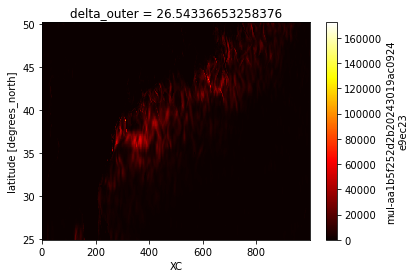

<xarray.Dataset>
Dimensions:      (XC: 1000, XG: 1000, YC: 303, YG: 303, delta: 54, delta_outer: 55, time: 73)
Coordinates:
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XG           (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: XC, time
Data variables:
    tmp11_0      (time, YG, XC, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    tmp11_1      (time, YG, XC, delta_outer) float32 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981


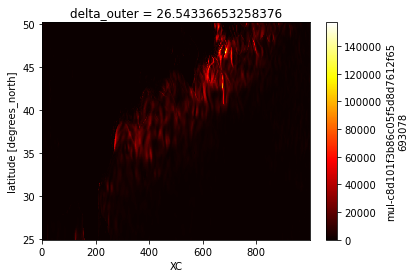

<xarray.Dataset>
Dimensions:      (XC: 1000, XG: 1000, YC: 303, YG: 303, delta: 54, delta_outer: 55, time: 73)
Coordinates:
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XG           (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: XC, time
Data variables:
    tmp11_0      (time, YG, XC, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    tmp11_1      (time, YG, XC, delta_outer) float32 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991


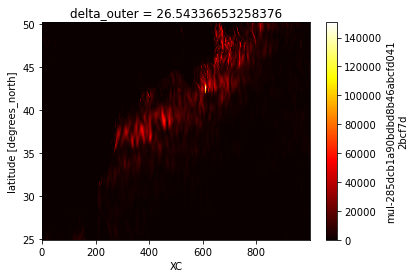

<xarray.Dataset>
Dimensions:      (XC: 1000, XG: 1000, YC: 303, YG: 303, delta: 54, delta_outer: 55, time: 73)
Coordinates:
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XG           (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: XC, time
Data variables:
    tmp11_0      (time, YG, XC, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    tmp11_1      (time, YG, XC, delta_outer) float32 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001


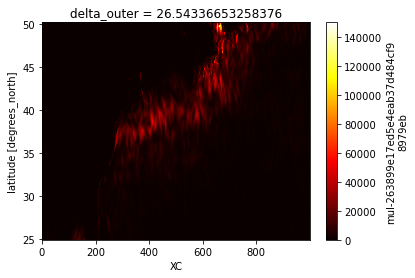

<xarray.Dataset>
Dimensions:      (XC: 1000, XG: 1000, YC: 303, YG: 303, delta: 54, delta_outer: 55, time: 73)
Coordinates:
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XG           (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: XC, time
Data variables:
    tmp11_0      (time, YG, XC, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    tmp11_1      (time, YG, XC, delta_outer) float32 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011


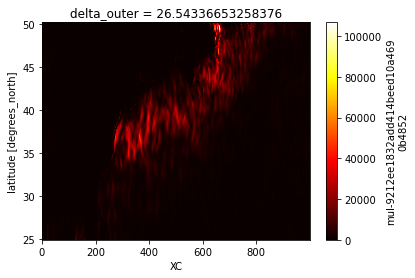

<xarray.Dataset>
Dimensions:      (XC: 1000, XG: 1000, YC: 303, YG: 303, delta: 54, delta_outer: 55, time: 73)
Coordinates:
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XG           (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: XC, time
Data variables:
    tmp11_0      (time, YG, XC, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    tmp11_1      (time, YG, XC, delta_outer) float32 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
2012


In [45]:
dyy = 10
n10 = 0
yy = int(n10*dyy)
imemb = 0

for year in years[int(n10*dyy):]:
    
    if yy % dyy == 0:
        ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                   % (imemb,year))
                          ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')
        ds7 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zps/ann/run%4d/' 
                                   % (imemb,year))
                          ).chunk({'XC':xchunk,'XG':xchunk}
                                                   ).drop_vars('time')
        ds8 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dynps/ann/run%4d/' 
                                       % (imemb,year))
                              ).chunk({'XC':xchunk,'XG':xchunk}
                                                   ).drop_vars('time')
        ds11 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Pps/ann/run%4d/' 
                                        % (imemb,year))
                               ).chunk({'XC':xchunk,'XG':xchunk}
                                                    ).drop_vars('time')
    else:
        tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                    % (imemb,year))
                           ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')

        ds2 = xr.concat([ds2,tmp2], 'Nyr')
        tmp2.close()
        tmp7 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zps/ann/run%4d/' 
                                    % (imemb,year))
                            ).chunk({'XC':xchunk,'XG':xchunk}
                                                    ).drop_vars('time')
        ds7 = xr.concat([ds7,tmp7], 'Nyr')
        tmp7.close()
        tmp8 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dynps/ann/run%4d/' 
                                    % (imemb,year))
                           ).chunk({'XC':xchunk,'XG':xchunk}
                                                    ).drop_vars('time')
        ds8 = xr.concat([ds8,tmp8], 'Nyr')
        tmp8.close()
        tmp11 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Pps/ann/run%4d/' 
                                     % (imemb,year))
                            ).chunk({'XC':xchunk,'XG':xchunk}
                                                     ).drop_vars('time')
        ds11 = xr.concat([ds11,tmp11], 'Nyr')
        tmp11.close()
        
    delta = .5*(ds2.delta_outer[1:].data 
                + ds2.delta_outer[:-1].data)
    buoyb = -grav * ds2.delta * rhoConst**-1
    buoybp1 = -grav * ds2.delta_outer * rhoConst**-1

    grid = Grid(ds2, periodic=['X'], 
                coords={'Z':{'center':'delta','outer':'delta_outer'},
                        'Y':{'center':'YC','left':'YG'},
                        'X':{'center':'XC','left':'XG'}}
    )
    
    if (yy - dyy+1) % dyy == 0:
        dzetaFy = ds2.dzetaFy.where(ds2.dzetaFy!=0.)
        sigmay = dzetaFy * -grid.diff(buoyb,'Z',boundary='fill',to='outer').data**-1

        vpp = ds8.vpp
        zetayp = ds7.zetayp
        
##############################        
        tmp11_0 = xr.DataArray((vpp**2*sigmay).data,
                               dims=['Nyr','time','YG','XC','delta_outer'],
                               coords={'YG':ds6.YG,'XG':ds6.XC,
                                       'delta_outer':ds6.delta_outer}
        ).sum('Nyr',skipna=True)
        tmp11_1 = xr.DataArray(.5*(zetayp**2).data,
                               dims=['Nyr','time','YG','XC','delta_outer'],
                               coords={'YG':ds6.YG,'XG':ds6.XC,
                                       'delta_outer':ds6.delta_outer}
        ).sum('Nyr',skipna=True)
        (tmp11_0.isel(time=0)).isel(delta_outer=23).plot(cmap='hot')
        plt.show()

##############################
        dsave = tmp11_0.to_dataset(name='tmp11_0')
        dsave['tmp11_1'] = tmp11_1
        
        dsave.coords['YC'] = ('YC',ds2.YC.data)
        dsave.coords['XG'] = ('XG',ds2.XG.data)
        dsave.coords['delta'] = ('delta',delta)

        try:
            del dsave['tmp11_0'].encoding['chunks']
            del dsave['tmp11_1'].encoding['chunks']
        except:
            pass
    
        print(dsave)
        dsave.to_zarr(op.join(tdgs,'5Dave/memb%02d/tmpE-P_summed/ann/11/%02d-%02d' 
                              % (imemb,yy-dyy+1,yy)), mode='w'
        )

        dsave.close()
        ds2.close()
        ds7.close()
        ds8.close()
        ds11.close()

    print(year)
    yy += 1

/tmp/ipykernel_39321/3519671576.py:9: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_39321/3519671576.py:12: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolid

1963


/tmp/ipykernel_39321/3519671576.py:25: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_39321/3519671576.py:31: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consol

1964
1965
1966
1967
1968
1969
1970
1971


<xarray.Dataset>
Dimensions:      (YC: 303, XG: 1000, delta_outer: 55, time: 73, YG: 303, XC: 1000, delta: 54)
Coordinates:
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * XG           (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: time
Data variables:
    tmp01        (time, YC, XG, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
1972


/tmp/ipykernel_39321/3519671576.py:9: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_39321/3519671576.py:12: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolid

1973


/tmp/ipykernel_39321/3519671576.py:25: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_39321/3519671576.py:31: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consol

1974
1975
1976
1977
1978
1979
1980
1981


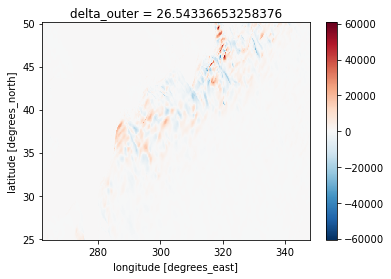

<xarray.Dataset>
Dimensions:      (YC: 303, XG: 1000, delta_outer: 55, time: 73, YG: 303, XC: 1000, delta: 54)
Coordinates:
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * XG           (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: time
Data variables:
    tmp01        (time, YC, XG, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
1982


/tmp/ipykernel_39321/3519671576.py:9: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_39321/3519671576.py:12: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolid

1983


/tmp/ipykernel_39321/3519671576.py:25: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_39321/3519671576.py:31: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consol

1984
1985
1986
1987
1988
1989
1990
1991


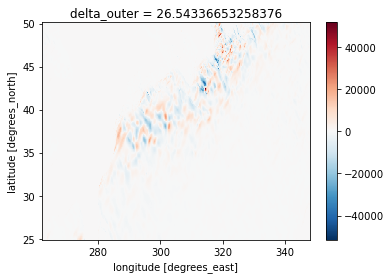

<xarray.Dataset>
Dimensions:      (YC: 303, XG: 1000, delta_outer: 55, time: 73, YG: 303, XC: 1000, delta: 54)
Coordinates:
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * XG           (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: time
Data variables:
    tmp01        (time, YC, XG, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
1992


/tmp/ipykernel_39321/3519671576.py:9: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_39321/3519671576.py:12: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolid

1993


/tmp/ipykernel_39321/3519671576.py:25: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_39321/3519671576.py:31: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consol

1994
1995
1996
1997
1998
1999
2000
2001


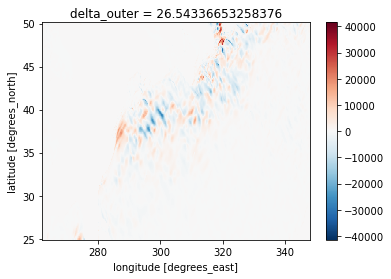

<xarray.Dataset>
Dimensions:      (YC: 303, XG: 1000, delta_outer: 55, time: 73, YG: 303, XC: 1000, delta: 54)
Coordinates:
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * XG           (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: time
Data variables:
    tmp01        (time, YC, XG, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
2002


/tmp/ipykernel_39321/3519671576.py:9: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_39321/3519671576.py:12: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolid

2003


/tmp/ipykernel_39321/3519671576.py:25: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_39321/3519671576.py:31: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consol

2004
2005
2006
2007
2008
2009
2010
2011


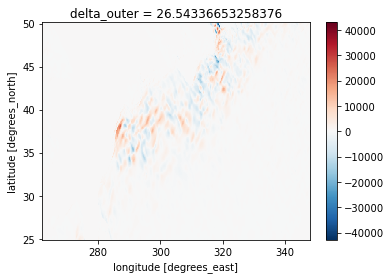

<xarray.Dataset>
Dimensions:      (YC: 303, XG: 1000, delta_outer: 55, time: 73, YG: 303, XC: 1000, delta: 54)
Coordinates:
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * XG           (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: time
Data variables:
    tmp01        (time, YC, XG, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
2012


In [13]:
dyy = 10
n10 = 0
yy = int(n10*dyy)
imemb = 0

for year in years[int(n10*dyy):]:
    
    if yy % dyy == 0:
        ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                   % (imemb,year))
                          ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')
        ds7 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zps/ann/run%4d/' 
                                   % (imemb,year))
                          ).chunk({'XC':xchunk,'XG':xchunk}
                                                   ).drop_vars('time')
        ds8 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dynps/ann/run%4d/' 
                                       % (imemb,year))
                              ).chunk({'XC':xchunk,'XG':xchunk}
                                                   ).drop_vars('time')
        ds11 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Pps/ann/run%4d/' 
                                        % (imemb,year))
                               ).chunk({'XC':xchunk,'XG':xchunk}
                                                    ).drop_vars('time')
    else:
        tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                    % (imemb,year))
                           ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')

        ds2 = xr.concat([ds2,tmp2], 'Nyr')
        tmp2.close()
        tmp7 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zps/ann/run%4d/' 
                                    % (imemb,year))
                            ).chunk({'XC':xchunk,'XG':xchunk}
                                                    ).drop_vars('time')
        ds7 = xr.concat([ds7,tmp7], 'Nyr')
        tmp7.close()
        tmp8 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dynps/ann/run%4d/' 
                                    % (imemb,year))
                           ).chunk({'XC':xchunk,'XG':xchunk}
                                                    ).drop_vars('time')
        ds8 = xr.concat([ds8,tmp8], 'Nyr')
        tmp8.close()
        tmp11 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Pps/ann/run%4d/' 
                                     % (imemb,year))
                            ).chunk({'XC':xchunk,'XG':xchunk}
                                                     ).drop_vars('time')
        ds11 = xr.concat([ds11,tmp11], 'Nyr')
        tmp11.close()
        
    delta = .5*(ds2.delta_outer[1:].data 
                + ds2.delta_outer[:-1].data)
    buoyb = -grav * ds2.delta * rhoConst**-1
    buoybp1 = -grav * ds2.delta_outer * rhoConst**-1

    grid = Grid(ds2, periodic=['X'], 
                coords={'Z':{'center':'delta','outer':'delta_outer'},
                        'Y':{'center':'YC','left':'YG'},
                        'X':{'center':'XC','left':'XG'}}
    )
    
    if (yy - dyy+1) % dyy == 0:
        dzetaFy = ds2.dzetaFy.where(ds2.dzetaFy!=0.)
        dzetaFx = ds2.dzetaFx.where(ds2.dzetaFx!=0.)
        sigmay = dzetaFy * -grid.diff(buoyb,'Z',boundary='fill',to='outer').data**-1
        sigmax = dzetaFx * -grid.diff(buoyb,'Z',boundary='fill',to='outer').data**-1

        upp = ds8.upp
        vpp = ds8.vpp
        
##############################        
        tmp01 = (grid.interp(grid.interp(xr.DataArray(vpp.data, 
                                                      dims=['Nyr','time','YG','XC','delta_outer'],
                                                      coords={'YG':ds6.YG,'XG':ds6.XC,
                                                              'delta_outer':ds6.delta_outer}
                                                     ),'X'),'Y',boundary='fill'
                            ).chunk({'YC':ychunk,'XG':xchunk,'delta_outer':schunk})
                 * xr.DataArray((upp*sigmax).data,
                                dims=['Nyr','time','YC','XG','delta_outer'],
                                coords={'YC':ds6.YC,'XG':ds6.XG,
                                        'delta_outer':ds6.delta_outer})
        ).sum('Nyr',skipna=True)
        tmp01.isel(time=0, delta_outer=23).plot()
        plt.show()

##############################
        dsave = tmp01.to_dataset(name='tmp01')
        
        dsave.coords['YG'] = ('YG',ds2.YG.data)
        dsave.coords['XC'] = ('XC',ds2.XC.data)
        dsave.coords['delta'] = ('delta',delta)

        try:
            del dsave['tmp01'].encoding['chunks']
        except:
            pass

        print(dsave)
        dsave.to_zarr(op.join(tdgs,'5Dave/memb%02d/tmpE-P_summed/ann/01/%02d-%02d' 
                              % (imemb,yy-dyy+1,yy)), mode='w'
        )

        dsave.close()
        ds2.close()
        ds7.close()
        ds8.close()
        ds11.close()

    print(year)
    yy += 1

/tmp/ipykernel_39321/1075624679.py:9: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_39321/1075624679.py:12: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolid

1993


/tmp/ipykernel_39321/1075624679.py:25: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_39321/1075624679.py:31: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consol

1994
1995
1996
1997
1998
1999
2000
2001


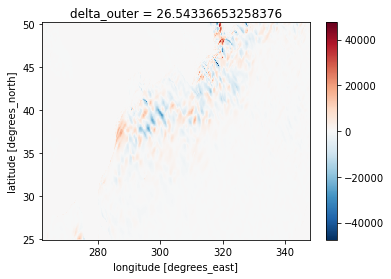

<xarray.Dataset>
Dimensions:      (XC: 1000, YG: 303, delta_outer: 55, XG: 1000, time: 73, YC: 303, delta: 54)
Coordinates:
  * XC           (XC) float64 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * XG           (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: time
Data variables:
    tmp10        (time, YG, XC, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
2002


/tmp/ipykernel_39321/1075624679.py:9: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_39321/1075624679.py:12: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolid

2003


/tmp/ipykernel_39321/1075624679.py:25: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_39321/1075624679.py:31: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consol

2004
2005
2006
2007
2008
2009
2010
2011


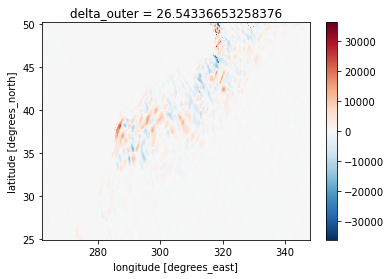

<xarray.Dataset>
Dimensions:      (XC: 1000, YG: 303, delta_outer: 55, XG: 1000, time: 73, YC: 303, delta: 54)
Coordinates:
  * XC           (XC) float64 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * XG           (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: time
Data variables:
    tmp10        (time, YG, XC, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
2012


In [18]:
dyy = 10
n10 = 3
yy = int(n10*dyy)
imemb = 0

for year in years[int(n10*dyy):]:
    
    if yy % dyy == 0:
        ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                   % (imemb,year))
                          ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')
        ds7 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zps/ann/run%4d/' 
                                   % (imemb,year))
                          ).chunk({'XC':xchunk,'XG':xchunk}
                                                   ).drop_vars('time')
        ds8 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dynps/ann/run%4d/' 
                                       % (imemb,year))
                              ).chunk({'XC':xchunk,'XG':xchunk}
                                                   ).drop_vars('time')
        ds11 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Pps/ann/run%4d/' 
                                        % (imemb,year))
                               ).chunk({'XC':xchunk,'XG':xchunk}
                                                    ).drop_vars('time')
    else:
        tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                    % (imemb,year))
                           ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')

        ds2 = xr.concat([ds2,tmp2], 'Nyr')
        tmp2.close()
        tmp7 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zps/ann/run%4d/' 
                                    % (imemb,year))
                            ).chunk({'XC':xchunk,'XG':xchunk}
                                                    ).drop_vars('time')
        ds7 = xr.concat([ds7,tmp7], 'Nyr')
        tmp7.close()
        tmp8 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dynps/ann/run%4d/' 
                                    % (imemb,year))
                           ).chunk({'XC':xchunk,'XG':xchunk}
                                                    ).drop_vars('time')
        ds8 = xr.concat([ds8,tmp8], 'Nyr')
        tmp8.close()
        tmp11 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Pps/ann/run%4d/' 
                                     % (imemb,year))
                            ).chunk({'XC':xchunk,'XG':xchunk}
                                                     ).drop_vars('time')
        ds11 = xr.concat([ds11,tmp11], 'Nyr')
        tmp11.close()
        
    delta = .5*(ds2.delta_outer[1:].data 
                + ds2.delta_outer[:-1].data)
    buoyb = -grav * ds2.delta * rhoConst**-1
    buoybp1 = -grav * ds2.delta_outer * rhoConst**-1

    grid = Grid(ds2, periodic=['X'], 
                coords={'Z':{'center':'delta','outer':'delta_outer'},
                        'Y':{'center':'YC','left':'YG'},
                        'X':{'center':'XC','left':'XG'}}
    )
    
    if (yy - dyy+1) % dyy == 0:
        dzetaFy = ds2.dzetaFy.where(ds2.dzetaFy!=0.)
        dzetaFx = ds2.dzetaFx.where(ds2.dzetaFx!=0.)
        sigmay = dzetaFy * -grid.diff(buoyb,'Z',boundary='fill',to='outer').data**-1
        sigmax = dzetaFx * -grid.diff(buoyb,'Z',boundary='fill',to='outer').data**-1

        upp = ds8.upp
        vpp = ds8.vpp
        
##############################        
        tmp10 = (grid.interp(grid.interp(xr.DataArray(upp.data, 
                                                      dims=['Nyr','time','YC','XG','delta_outer'],
                                                      coords={'YC':ds6.YC,'XG':ds6.XG,
                                                              'delta_outer':ds6.delta_outer}
                                                     ),'X'),'Y',boundary='fill'
                            ).chunk({'YG':ychunk,'XC':xchunk,'delta_outer':schunk}) 
                 * xr.DataArray((vpp*sigmay).data,
                                dims=['Nyr','time','YG','XC','delta_outer'],
                                coords={'YG':ds6.YG,'XG':ds6.XC,
                                        'delta_outer':ds6.delta_outer}
                               )
        ).sum('Nyr',skipna=True)
        tmp10.isel(time=0, delta_outer=23).plot()
        plt.show()

##############################
        dsave = tmp10.to_dataset(name='tmp10')
        
        dsave.coords['YC'] = ('YC',ds2.YC.data)
        dsave.coords['XG'] = ('XG',ds2.XG.data)
        dsave.coords['delta'] = ('delta',delta)

        try:
            del dsave['tmp10'].encoding['chunks']
        except:
            pass

        print(dsave)
        dsave.to_zarr(op.join(tdgs,'5Dave/memb%02d/tmpE-P_summed/ann/10/%02d-%02d' 
                              % (imemb,yy-dyy+1,yy)), mode='w'
        )

        dsave.close()
        ds2.close()
        ds7.close()
        ds8.close()
        ds11.close()

    print(year)
    yy += 1

/tmp/ipykernel_30429/1346555146.py:9: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_30429/1346555146.py:12: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolid

2003


/tmp/ipykernel_30429/1346555146.py:25: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_30429/1346555146.py:31: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consol

2004
2005
2006
2007
2008
2009
2010
2011


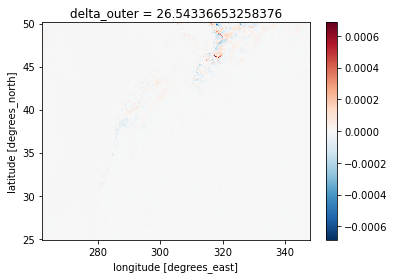

<xarray.Dataset>
Dimensions:      (XC: 1000, YC: 303, delta_outer: 55, time: 73, YG: 303, XG: 1000, delta: 54)
Coordinates:
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XG           (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: time
Data variables:
    tmp20_0      (time, YC, XC, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    tmp20_1      (time, YC, XC, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
2012


In [15]:
dyy = 10
n10 = 4
yy = int(n10*dyy)
imemb = 0

for year in years[int(n10*dyy):]:
    
    if yy % dyy == 0:
        ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                   % (imemb,year))
                          ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')
        ds7 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zps/ann/run%4d/' 
                                   % (imemb,year))
                          ).chunk({'XC':xchunk,'XG':xchunk}
                                                   ).drop_vars('time')
        ds8 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dynps/ann/run%4d/' 
                                       % (imemb,year))
                              ).chunk({'XC':xchunk,'XG':xchunk}
                                                   ).drop_vars('time')
        ds11 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Pps/ann/run%4d/' 
                                        % (imemb,year))
                               ).chunk({'XC':xchunk,'XG':xchunk}
                                                    ).drop_vars('time')
    else:
        tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                    % (imemb,year))
                           ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')

        ds2 = xr.concat([ds2,tmp2], 'Nyr')
        tmp2.close()
        tmp7 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zps/ann/run%4d/' 
                                    % (imemb,year))
                            ).chunk({'XC':xchunk,'XG':xchunk}
                                                    ).drop_vars('time')
        ds7 = xr.concat([ds7,tmp7], 'Nyr')
        tmp7.close()
        tmp8 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dynps/ann/run%4d/' 
                                    % (imemb,year))
                           ).chunk({'XC':xchunk,'XG':xchunk}
                                                    ).drop_vars('time')
        ds8 = xr.concat([ds8,tmp8], 'Nyr')
        tmp8.close()
        tmp11 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Pps/ann/run%4d/' 
                                     % (imemb,year))
                            ).chunk({'XC':xchunk,'XG':xchunk}
                                                     ).drop_vars('time')
        ds11 = xr.concat([ds11,tmp11], 'Nyr')
        tmp11.close()
        
    delta = .5*(ds2.delta_outer[1:].data 
                + ds2.delta_outer[:-1].data)
    buoyb = -grav * ds2.delta * rhoConst**-1
    buoybp1 = -grav * ds2.delta_outer * rhoConst**-1

    grid = Grid(ds2, periodic=['X'], 
                coords={'Z':{'center':'delta','outer':'delta_outer'},
                        'Y':{'center':'YC','left':'YG'},
                        'X':{'center':'XC','left':'XG'}}
    )
    
    if (yy - dyy+1) % dyy == 0:
        dzetaF = ds2.dzetaF.where(ds2.dzetaF!=0.)
        sigma = dzetaF * -grid.diff(buoyb,'Z',boundary='fill',to='outer').data**-1

        upp = ds8.upp
        varpipp = ds8.varpipp
        
        zetaxp = ds7.zetaxp
        mbxp = ds11.mbxp
        
##############################        
        tmp20_0 = (varpipp*grid.interp(xr.DataArray(upp.data,
                                                    dims=['Nyr','time','YC','XG','delta_outer'],
                                                    coords={'YC':ds6.YC,'XG':ds6.XG,
                                                            'delta_outer':ds6.delta_outer}
                                                   ),'X'
                                      ).chunk({'YC':ychunk,'XC':xchunk,'delta_outer':schunk})
                   * sigma
                  ).sum('Nyr',skipna=True)
        tmp20_1 = grid.interp(xr.DataArray((mbxp*zetaxp).data,
                                           dims=['Nyr','time','YC','XG','delta_outer'],
                                           coords={'YC':ds6.YC,'XG':ds6.XG,
                                                   'delta_outer':ds6.delta_outer}
                                          ),'X'
                             ).chunk({'YC':ychunk,'XC':xchunk,'delta_outer':schunk}).sum('Nyr',skipna=True)
        tmp20_0.isel(time=0, delta_outer=23).plot()
        plt.show()

##############################
        dsave = tmp20_0.to_dataset(name='tmp20_0')
        dsave['tmp20_1'] = tmp20_1
        
        dsave.coords['YG'] = ('YG',ds2.YG.data)
        dsave.coords['XG'] = ('XG',ds2.XG.data)
        dsave.coords['delta'] = ('delta',delta)

        try:
            del dsave['tmp20_0'].encoding['chunks']
            del dsave['tmp20_1'].encoding['chunks']
        except:
            pass
    
        print(dsave)
        dsave.to_zarr(op.join(tdgs,'5Dave/memb%02d/tmpE-P_summed/ann/20/%02d-%02d' 
                              % (imemb,yy-dyy+1,yy)), mode='w'
        )

        dsave.close()
        ds2.close()
        ds7.close()
        ds8.close()
        ds11.close()

    print(year)
    yy += 1

/tmp/ipykernel_27653/2985859927.py:9: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_27653/2985859927.py:13: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolid

1978


/tmp/ipykernel_27653/2985859927.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_27653/2985859927.py:27: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consol

1979
1980
1981


<xarray.Dataset>
Dimensions:      (XC: 1000, YC: 303, delta_outer: 55, time: 73, YG: 303, XG: 1000, delta: 54)
Coordinates:
  * XC           (XC) float64 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XG           (XG) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: time
Data variables:
    tmp21_0      (time, YC, XC, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
1982


/tmp/ipykernel_27653/2985859927.py:9: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_27653/2985859927.py:13: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolid

1983


/tmp/ipykernel_27653/2985859927.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_27653/2985859927.py:27: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consol

1984
1985
1986


<xarray.Dataset>
Dimensions:      (XC: 1000, YC: 303, delta_outer: 55, time: 73, YG: 303, XG: 1000, delta: 54)
Coordinates:
  * XC           (XC) float64 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XG           (XG) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: time
Data variables:
    tmp21_0      (time, YC, XC, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
1987


/tmp/ipykernel_27653/2985859927.py:9: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_27653/2985859927.py:13: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolid

1988


/tmp/ipykernel_27653/2985859927.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_27653/2985859927.py:27: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consol

1989
1990
1991


<xarray.Dataset>
Dimensions:      (XC: 1000, YC: 303, delta_outer: 55, time: 73, YG: 303, XG: 1000, delta: 54)
Coordinates:
  * XC           (XC) float64 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XG           (XG) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: time
Data variables:
    tmp21_0      (time, YC, XC, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
1992


/tmp/ipykernel_27653/2985859927.py:9: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_27653/2985859927.py:13: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolid

1993


/tmp/ipykernel_27653/2985859927.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_27653/2985859927.py:27: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consol

1994
1995
1996


<xarray.Dataset>
Dimensions:      (XC: 1000, YC: 303, delta_outer: 55, time: 73, YG: 303, XG: 1000, delta: 54)
Coordinates:
  * XC           (XC) float64 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XG           (XG) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: time
Data variables:
    tmp21_0      (time, YC, XC, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
1997


/tmp/ipykernel_27653/2985859927.py:9: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_27653/2985859927.py:13: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolid

1998


/tmp/ipykernel_27653/2985859927.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_27653/2985859927.py:27: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consol

1999
2000
2001


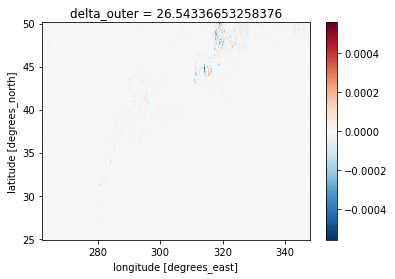

<xarray.Dataset>
Dimensions:      (XC: 1000, YC: 303, delta_outer: 55, time: 73, YG: 303, XG: 1000, delta: 54)
Coordinates:
  * XC           (XC) float64 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XG           (XG) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: time
Data variables:
    tmp21_0      (time, YC, XC, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
2002


/tmp/ipykernel_27653/2985859927.py:9: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_27653/2985859927.py:13: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolid

2003


/tmp/ipykernel_27653/2985859927.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_27653/2985859927.py:27: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consol

2004
2005
2006


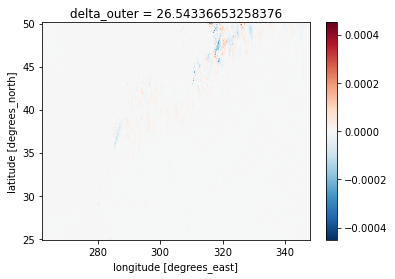

<xarray.Dataset>
Dimensions:      (XC: 1000, YC: 303, delta_outer: 55, time: 73, YG: 303, XG: 1000, delta: 54)
Coordinates:
  * XC           (XC) float64 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XG           (XG) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: time
Data variables:
    tmp21_0      (time, YC, XC, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
2007


/tmp/ipykernel_27653/2985859927.py:9: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_27653/2985859927.py:13: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolid

2008


/tmp/ipykernel_27653/2985859927.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_27653/2985859927.py:27: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consol

2009
2010
2011


<xarray.Dataset>
Dimensions:      (XC: 1000, YC: 303, delta_outer: 55, time: 73, YG: 303, XG: 1000, delta: 54)
Coordinates:
  * XC           (XC) float64 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XG           (XG) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: time
Data variables:
    tmp21_0      (time, YC, XC, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
2012


In [ ]:
dyy = 5
n10 = 3
yy = int(n10*dyy)
imemb = 0

for year in years[int(n10*dyy):]:
    
    if yy % dyy == 0:
        ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                   % (imemb,year))
                          ).chunk({'XC':xchunk,'XG':xchunk,
                                   'delta_outer':1,'deltay_outer':1,'deltax_outer':1}).drop_vars('time')
        ds8 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dynps/ann/run%4d/' 
                                       % (imemb,year))
                              ).chunk({'XC':xchunk,'XG':xchunk,
                                       'delta_outer':1,'deltay_outer':1,'deltax_outer':1}
                                     ).drop_vars('time')
    else:
        tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                    % (imemb,year))
                           ).chunk({'XC':xchunk,'XG':xchunk,
                                    'delta_outer':1,'deltay_outer':1,'deltax_outer':1}
                                  ).drop_vars('time')

        ds2 = xr.concat([ds2,tmp2], 'Nyr')
        tmp2.close()
        tmp8 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dynps/ann/run%4d/' 
                                    % (imemb,year))
                           ).chunk({'XC':xchunk,'XG':xchunk,
                                    'delta_outer':1,'deltay_outer':1,'deltax_outer':1}
                                  ).drop_vars('time')
        ds8 = xr.concat([ds8,tmp8], 'Nyr')
        tmp8.close()

        
    delta = .5*(ds2.delta_outer[1:].data 
                + ds2.delta_outer[:-1].data)
    buoyb = -grav * ds2.delta * rhoConst**-1
    buoybp1 = -grav * ds2.delta_outer * rhoConst**-1

    grid = Grid(ds2, periodic=['X'], 
                coords={'Z':{'center':'delta','outer':'delta_outer'},
                        'Y':{'center':'YC','left':'YG'},
                        'X':{'center':'XC','left':'XG'}}
    )
    
    if (yy - dyy+1) % dyy == 0:
        dzetaF = ds2.dzetaF.where(ds2.dzetaF!=0.)
        sigma = dzetaF * -grid.diff(buoyb,'Z',boundary='fill',to='outer').data**-1

        vpp = grid.interp(xr.DataArray(ds8.vpp.data,
                                       dims=['Nyr','time','YG','XC','delta_outer'],
                                       coords={'YG':ds6.YG,'XG':ds6.XC,
                                               'delta_outer':ds6.delta_outer}
                                      ),'Y',boundary='fill'
                         ).chunk({'YC':ychunk,'XC':xchunk})
        varpipp = ds8.varpipp
        
##############################        
        tmp21_0 = (varpipp*vpp
                   * sigma
                  ).sum('Nyr',skipna=True)

        tmp21_0.isel(time=0, delta_outer=23).plot()
        plt.show()

##############################
        dsave = tmp21_0.to_dataset(name='tmp21_0')
        
        dsave.coords['YG'] = ('YG',ds2.YG.data)
        dsave.coords['XG'] = ('XG',ds2.XC.data)
        dsave.coords['delta'] = ('delta',delta)

        try:
            del dsave['tmp21_0'].encoding['chunks']
        except:
            pass
        
        dsave = dsave.chunk({'delta_outer':schunk})
        print(dsave)
        dsave.to_zarr(op.join(tdgs,'5Dave/memb%02d/tmpE-P_summed/ann/21_0/%02d-%02d' 
                              % (imemb,yy-dyy+1,yy)), mode='w'
        )

        dsave.close()
        ds2.close()
        ds8.close()

    print(year)
    yy += 1

/tmp/ipykernel_30912/1925914798.py:9: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_30912/1925914798.py:12: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolid

1998


/tmp/ipykernel_30912/1925914798.py:27: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  tmp7 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zps/ann/run%4d/'
/tmp/ipykernel_30912/1925914798.py:33: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidate

1999
2000
2001


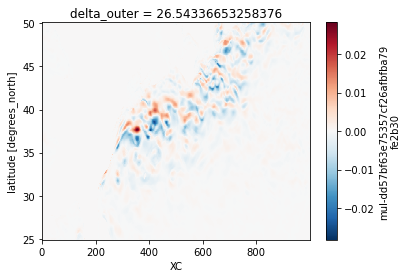

<xarray.Dataset>
Dimensions:      (YC: 303, delta_outer: 55, time: 73, XC: 1000, YG: 303, XG: 1000, delta: 54)
Coordinates:
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XG           (XG) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: time, XC
Data variables:
    tmp21_1      (time, YC, XC, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
2002


/tmp/ipykernel_30912/1925914798.py:9: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_30912/1925914798.py:12: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolid

2003


/tmp/ipykernel_30912/1925914798.py:21: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_30912/1925914798.py:27: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consol

2004
2005
2006


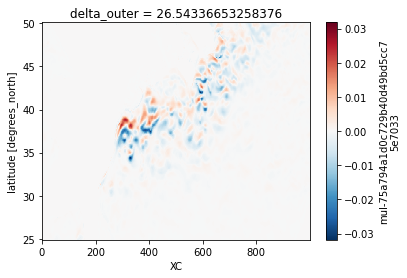

<xarray.Dataset>
Dimensions:      (YC: 303, delta_outer: 55, time: 73, XC: 1000, YG: 303, XG: 1000, delta: 54)
Coordinates:
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XG           (XG) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: time, XC
Data variables:
    tmp21_1      (time, YC, XC, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
2007


/tmp/ipykernel_30912/1925914798.py:9: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_30912/1925914798.py:12: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolid

2008


/tmp/ipykernel_30912/1925914798.py:21: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/'
/tmp/ipykernel_30912/1925914798.py:27: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consol

2009
2010
2011


<xarray.Dataset>
Dimensions:      (YC: 303, delta_outer: 55, time: 73, XC: 1000, YG: 303, XG: 1000, delta: 54)
Coordinates:
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XG           (XG) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: time, XC
Data variables:
    tmp21_1      (time, YC, XC, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
2012


In [10]:
dyy = 5
n10 = 7
yy = int(n10*dyy)
imemb = 0

for year in years[int(n10*dyy):]:
    
    if yy % dyy == 0:
        ds2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                   % (imemb,year))
                          ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')
        ds7 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zps/ann/run%4d/' 
                                   % (imemb,year))
                          ).chunk({'XC':xchunk,'XG':xchunk}
                                                   ).drop_vars('time')
        ds11 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Pps/ann/run%4d/' 
                                        % (imemb,year))
                               ).chunk({'XC':xchunk,'XG':xchunk}
                                                    ).drop_vars('time')
    else:
        tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zs_rechunked/run%4d/' 
                                    % (imemb,year))
                           ).chunk({'XC':xchunk,'XG':xchunk}).drop_vars('time')

        ds2 = xr.concat([ds2,tmp2], 'Nyr')
        tmp2.close()
        tmp7 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zps/ann/run%4d/' 
                                    % (imemb,year))
                            ).chunk({'XC':xchunk,'XG':xchunk}
                                                    ).drop_vars('time')
        ds7 = xr.concat([ds7,tmp7], 'Nyr')
        tmp7.close()
        tmp11 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Pps/ann/run%4d/' 
                                     % (imemb,year))
                            ).chunk({'XC':xchunk,'XG':xchunk}
                                                     ).drop_vars('time')
        ds11 = xr.concat([ds11,tmp11], 'Nyr')
        tmp11.close()
        
    delta = .5*(ds2.delta_outer[1:].data 
                + ds2.delta_outer[:-1].data)
    buoyb = -grav * ds2.delta * rhoConst**-1
    buoybp1 = -grav * ds2.delta_outer * rhoConst**-1

    grid = Grid(ds2, periodic=['X'], 
                coords={'Z':{'center':'delta','outer':'delta_outer'},
                        'Y':{'center':'YC','left':'YG'},
                        'X':{'center':'XC','left':'XG'}}
    )
    
    if (yy - dyy+1) % dyy == 0:
        dzetaF = ds2.dzetaF.where(ds2.dzetaF!=0.)
        sigma = dzetaF * -grid.diff(buoyb,'Z',boundary='fill',to='outer').data**-1
        
        zetayp = ds7.zetayp
        mbyp = ds11.mbyp
        
##############################        
        tmp21_1 = grid.interp(xr.DataArray((mbyp*zetayp).chunk({'deltay_outer':1}).data,
                                           dims=['Nyr','time','YG','XC','delta_outer'],
                                           coords={'YG':ds6.YG,'XG':ds6.XC,
                                                   'delta_outer':ds6.delta_outer}
                                          ),'Y',boundary='fill'
                             ).chunk({'YC':ychunk,'XC':xchunk,'delta_outer':schunk}).sum('Nyr',skipna=True)

        tmp21_1.isel(time=0, delta_outer=23).plot()
        plt.show()

##############################
        dsave = tmp21_1.to_dataset(name='tmp21_1')
        
        dsave.coords['YG'] = ('YG',ds2.YG.data)
        dsave.coords['XG'] = ('XG',ds2.XC.data)
        dsave.coords['delta'] = ('delta',delta)

        try:
            del dsave['tmp21_1'].encoding['chunks']
        except:
            pass
    
        print(dsave)
        dsave.to_zarr(op.join(tdgs,'5Dave/memb%02d/tmpE-P_summed/ann/21_1/%02d-%02d' 
                              % (imemb,yy-dyy+1,yy)), mode='w'
        )

        dsave.close()
        ds2.close()
        ds7.close()
        ds11.close()

    print(year)
    yy += 1

In [10]:
imemb = 0
for year in years[yystart:]:
    ds10 = xr.open_zarr(op.join(savedir,'5Dave/memb%02d/tmpE-P/run%4d/' 
                                    % (imemb,year))
                           )
    
    ds10s = ds10.sum('time', skipna=True)
    ds10s.to_zarr(op.join(tdgs,'5Dave/memb%02d/tmpE-P_summed/clim/run%4d' 
                          % (imemb,year)), mode='w')
    if year == years[yystart]:
        print(ds10s)
    print(year)
    ds10s.close()
    ds10.close()

KeyboardInterrupt: 

In [ ]:
xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/tmpE-P_summed/ann/00/%02d-%02d' 
                                % (,yy-dyy+1,yy))
                       )

In [14]:
# Nt = 3650
imemb = 0
# yystart = 0
# Nseas = xr.DataArray(np.array([19,18,18,18]), dims='seas',
#                      coords={'seas':np.arange(4)}
#                     )

# for year in years[yystart:]:
    
#     ds10 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/tmpE-P_summed/run%4d/' 
#                                 % (imemb,year))
#                        )
dyy = 10

for yy in range(0,Nyears,dyy):
    ds00 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/tmpE-P_summed/ann/00/%02d-%02d' 
                                % (imemb,yy,yy+dyy-1))
                       )
    ds11 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/tmpE-P_summed/ann/11/%02d-%02d' 
                                % (imemb,yy,yy+dyy-1))
                       )
    ds20 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/tmpE-P_summed/ann/20/%02d-%02d' 
                                % (imemb,yy,yy+dyy-1))
                       )
    ds01 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/tmpE-P_summed/ann/01/%02d-%02d' 
                                % (imemb,yy,yy+dyy-1))
                       )
    ds10 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/tmpE-P_summed/ann/10/%02d-%02d' 
                                % (imemb,yy,yy+dyy-1))
                       )
    
#     if year == years[0]:
    if yy == 0:
        print(ds11)
        tmp00_0 = ds00.tmp00_0
        tmp00_1 = ds00.tmp00_1

        tmp11_0 = ds11.tmp11_0
        tmp11_1 = ds11.tmp11_1
        tmp01 = ds01.tmp01
        tmp10 = ds10.tmp10

        tmp20_0 = ds20.tmp20_0
        tmp20_1 = ds20.tmp20_1
    else:
        tmp00_0 = xr.concat([tmp00_0,ds00.tmp00_0], 'Nyr')
        tmp00_1 = xr.concat([tmp00_1,ds00.tmp00_1], 'Nyr')
        
        tmp11_0 = xr.concat([tmp11_0,ds11.tmp11_0], 'Nyr')
        tmp11_1 = xr.concat([tmp11_1,ds11.tmp11_1], 'Nyr')
        tmp01 = xr.concat([tmp01,ds01.tmp01], 'Nyr')
        tmp10 = xr.concat([tmp10,ds10.tmp10], 'Nyr')
        
        tmp20_0 = xr.concat([tmp20_0,ds20.tmp20_0], 'Nyr')
        tmp20_1 = xr.concat([tmp20_1,ds20.tmp20_1], 'Nyr')
    
    ds11.close()
    
dyy = 5
for yy in range(0,Nyears,dyy):
    if yy == 0:
        ds210 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/tmpE-P_summed/ann/21_0/%02d-%02d' 
                                     % (imemb,yy,int(yy+2*dyy-1)))
                            )
    elif yy >= 10:
        ds210 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/tmpE-P_summed/ann/21_0/%02d-%02d' 
                                     % (imemb,yy,yy+dyy-1))
                            )
    ds211 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/tmpE-P_summed/ann/21_1/%02d-%02d' 
                                 % (imemb,yy,yy+dyy-1))
                        )
    
    if yy == 0:
        tmp21_0 = ds210.tmp21_0
        tmp21_1 = ds211.tmp21_1
    else:
        tmp21_0 = xr.concat([tmp21_0,ds210.tmp21_0], 'Nyr')
        tmp21_1 = xr.concat([tmp21_1,ds211.tmp21_1], 'Nyr')
        

print(tmp00_0)
tmp00_0b = tmp00_0.sum('Nyr',skipna=True) / Nyears
tmp00_1b = tmp00_1.sum('Nyr',skipna=True) / Nyears
tmp11_0b = tmp11_0.sum('Nyr',skipna=True) / Nyears
tmp11_1b = tmp11_1.sum('Nyr',skipna=True) / Nyears

tmp01b = tmp01.sum('Nyr',skipna=True) / Nyears
tmp10b = tmp10.sum('Nyr',skipna=True) / Nyears

tmp20_0b = tmp20_0.sum('Nyr',skipna=True) / Nyears
tmp20_1b = tmp20_1.sum('Nyr',skipna=True) / Nyears
tmp21_0b = tmp21_0.sum('Nyr',skipna=True) / Nyears
tmp21_1b = tmp21_1.sum('Nyr',skipna=True) / Nyears

# print(tmp00_0b,tmp00_1b,tmp11_0b,tmp11_1b,tmp01b,tmp10b)
# print(tmp20_0b,tmp20_1b,tmp21_0b,tmp21_1b)

dsave = tmp00_0b.to_dataset(name='tmp00_0b')
dsave['tmp00_1b'] = tmp00_1b
dsave['tmp11_0b'] = tmp11_0b
dsave['tmp11_1b'] = tmp11_1b
dsave['tmp01b'] = tmp01b
dsave['tmp10b'] = tmp10b
dsave['tmp20_0b'] = tmp20_0b
dsave['tmp20_1b'] = tmp20_1b
dsave['tmp21_0b'] = tmp21_0b
dsave['tmp21_1b'] = tmp21_1b
try:
    del dsave['tmp00_0b'].encoding['chunks']
    del dsave['tmp00_1b'].encoding['chunks']
    del dsave['tmp11_0b'].encoding['chunks']
    del dsave['tmp11_1b'].encoding['chunks']
    del dsave['tmp01b'].encoding['chunks']
    del dsave['tmp10b'].encoding['chunks']
    del dsave['tmp20_0b'].encoding['chunks']
    del dsave['tmp20_1b'].encoding['chunks']
    del dsave['tmp21_0b'].encoding['chunks']
    del dsave['tmp21_1b'].encoding['chunks']
except:
    pass
print(dsave)
dsave.chunk({'XC':xchunk,'YC':ychunk,
             'delta_outer':schunk}).to_zarr(op.join(tdgs,'5Dave/memb%02d/tmpE-Pb/ann' 
                                                    % (imemb)), mode='w')
dsave.close()

/tmp/ipykernel_30912/146865782.py:16: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds00 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/tmpE-P_summed/ann/00/%02d-%02d'
/tmp/ipykernel_30912/146865782.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly settin

<xarray.Dataset>
Dimensions:      (XG: 1000, YC: 303, YG: 303, delta: 54, delta_outer: 55, time: 73, XC: 1000)
Coordinates:
  * XG           (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
Dimensions without coordinates: time, XC
Data variables:
    tmp11_0      (time, YG, XC, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    tmp11_1      (time, YG, XC, delta_outer) float32 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
<xarray.DataArray 'tmp00_0' (Nyr: 5, time: 73, YC: 303, XG: 1000, delta_outer: 55)>
dask.array<concatenate, shape=(5, 73, 303, 1000, 55), dtype=float64, chunksize=(1, 73, 101, 100, 5), chunktype=numpy.ndarray>
C

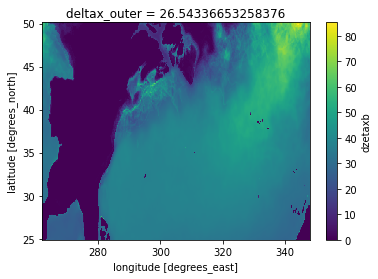

In [11]:
delta = .5*(ds6.delta_outer[1:].data 
            + ds6.delta_outer[:-1].data)
ds6.coords['delta'] = ('delta',delta)
buoyb = -grav * ds6.delta * rhoConst**-1
buoybp1 = -grav * ds6.delta_outer * rhoConst**-1

grid = Grid(ds6, periodic=['X'], 
            coords={'Z':{'center':'delta','outer':'delta_outer'},
                    'Y':{'center':'YC','left':'YG'},
                    'X':{'center':'XC','left':'XG'}}
           )

###############################
zetab = ds6.zetab
zetaxb = ds6.zetaxb
zetayb = ds6.zetayb

sigmab = (ds6.dzetab 
          * -grid.diff(buoyb,'Z',boundary='fill',to='outer').data**-1
         )
sigmaxb = (ds6.dzetaxb 
           * -grid.diff(buoyb,'Z',boundary='fill',to='outer').data**-1
          )
sigmayb = (ds6.dzetayb 
           * -grid.diff(buoyb,'Z',boundary='fill',to='outer').data**-1
          )
ds6.dzetaxb.isel(time=0,deltax_outer=23).plot()

In [13]:
ds10 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/tmpE-Pb/ann/' 
                            % (imemb))
                   )
# ds11 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/tmp21-1b/clim/' 
#                             % (imemb))
#                    )

tmp00_0b = ds10.tmp00_0b
tmp00_1b = ds10.tmp00_1b
tmp11_0b = ds10.tmp11_0b
tmp11_1b = ds10.tmp11_1b

tmp01b = ds10.tmp01b
tmp10b = ds10.tmp10b

tmp20_0b = ds10.tmp20_0b
tmp20_1b = ds10.tmp20_1b
tmp21_0b = ds10.tmp21_0b
tmp21_1b = ds10.tmp21_1b

In [17]:
e00 = ((tmp00_0b+tmp00_1b) 
       * xr.DataArray(sigmaxb.data,
                      dims=['time','YC','XG','delta_outer'],
                      coords={'YC':ds6.YC,'XG':ds6.XG,'delta_outer':ds6.delta_outer}
                     )**-1
      )
e01 = (tmp01b
       * xr.DataArray(sigmaxb.data,
                      dims=['time','YC','XG','delta_outer'],
                      coords={'YC':ds6.YC,'XG':ds6.XG,'delta_outer':ds6.delta_outer}
                     )**-1
      )
e10 = (tmp10b
       * xr.DataArray(sigmayb.data,
                      dims=['time','YG','XC','delta_outer'],
                      coords={'YG':ds6.YG,'XG':ds6.XC,'delta_outer':ds6.delta_outer}
                     )**-1
      )
e11 = ((tmp11_0b+tmp11_1b) 
       * xr.DataArray(sigmayb.data,
                      dims=['time','YG','XC','delta_outer'],
                      coords={'YG':ds6.YG,'XG':ds6.XC,'delta_outer':ds6.delta_outer}
                     )**-1
      )

e20_0 = (tmp20_0b * sigmab**-1)
e20_1 = (tmp20_1b * sigmab**-1)
e21_0 = (tmp21_0b * sigmab**-1)
e21_1 = (tmp21_1b * sigmab**-1)

dsave = e00.to_dataset(name='e00')
dsave['e01'] = e01
dsave['e10'] = e10
dsave['e11'] = e11

dsave['e20_0'] = e20_0
dsave['e20_1'] = e20_1
dsave['e21_0'] = e21_0
dsave['e21_1'] = e21_1

dsave.coords['YG'] = ('YG',ds6.YG.data)
dsave.coords['XG'] = ('XG',ds6.XG.data)
dsave.coords['delta'] = ('delta',ds6.delta.data)
try:
    del dsave['e00'].encoding['chunks']
    del dsave['e01'].encoding['chunks']
    del dsave['e10'].encoding['chunks']
    del dsave['e11'].encoding['chunks']
    del dsave['e20_0'].encoding['chunks']
    del dsave['e20_1'].encoding['chunks']
    del dsave['e21_0'].encoding['chunks']
    del dsave['e21_1'].encoding['chunks']
except:
    pass
print(dsave)
dsave.to_zarr(op.join(tdgs,'5Dave/memb%02d/E-P/ann' 
                      % (imemb)), mode='w')
dsave.close()

<xarray.Dataset>
Dimensions:      (XG: 1000, YC: 303, delta_outer: 55, time: 73, XC: 1000, YG: 303, delta: 54)
Coordinates:
  * XG           (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: time
Data variables:
    e00          (time, YC, XG, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    e01          (time, YC, XG, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    e10          (time, YG, XC, delta_outer) float64 dask.array<chunksize=(73, 101, 100, 5), meta=np.ndarray>
    e11          (time, YG, X

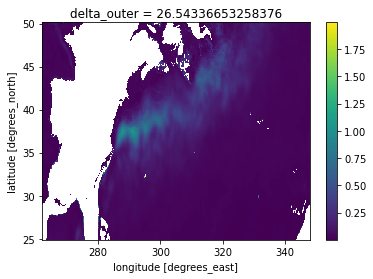

In [15]:
((tmp00_0b+tmp00_1b) 
       * xr.DataArray(sigmaxb.data,
                      dims=['time','YC','XG','delta_outer'],
                      coords={'YC':ds6.YC,'XG':ds6.XG,
                              'delta_outer':ds6.delta_outer}
                     )**-1
      ).isel(time=0,delta_outer=23).plot()

In [22]:
e20_0.isel(time=0,delta_outer=23).plot(vmax=1e-9)

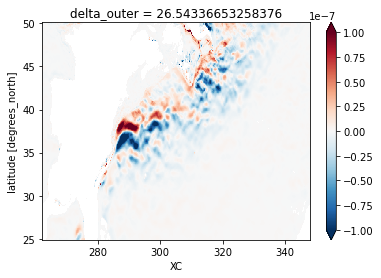

In [23]:
e21_1.isel(time=0,delta_outer=23).plot(vmax=1e-7)

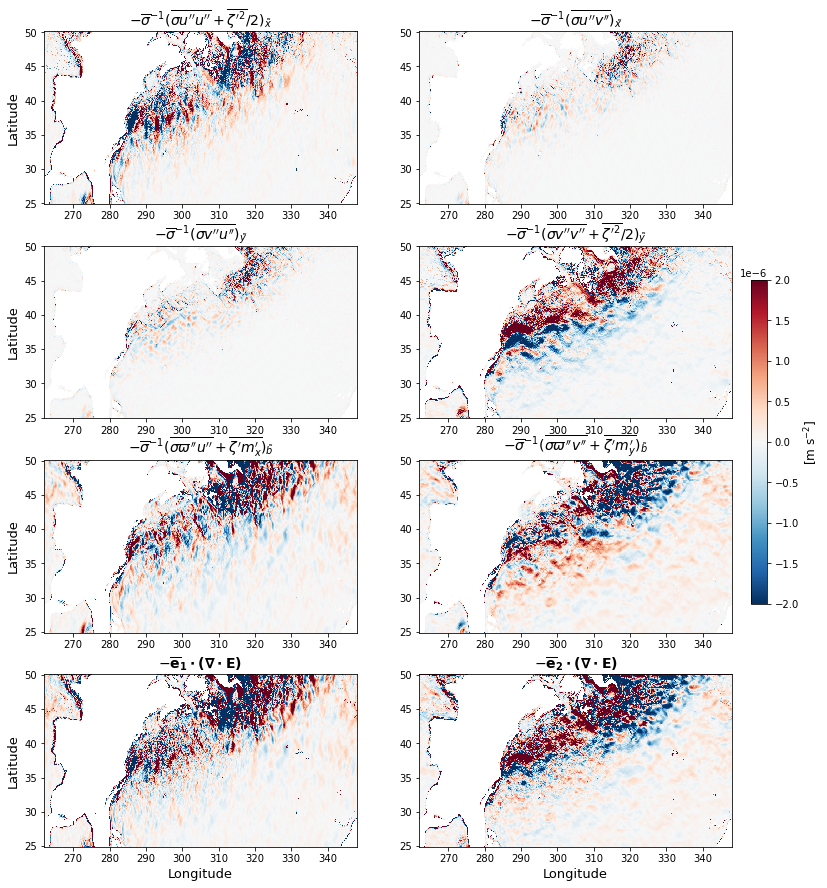

<xarray.Dataset>
Dimensions:      (YC: 303, XC: 1000, delta_outer: 55, time: 73, YG: 303, XG: 1000, delta: 54)
Coordinates:
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
    rA           (YC, XC) >f4 dask.array<chunksize=(101, 100), meta=np.ndarray>
    Depth        (YC, XC) >f4 dask.array<chunksize=(101, 100), meta=np.ndarray>
    maskInC      (YC, XC) bool dask.array<chunksize=(101, 100), meta=np.ndarray>
  * YG           (YG) float32 24.96 25.04 25.13 25.21 ... 49.96 50.04 50.13
  * XG           (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Dimensions without coordinates: time
Data variables:
    e00x         (time, YC, XC, delta_outer) float64 dask.array<chunksize=(73, 100, 99, 5), meta=np.ndarray>
    e01x 

In [26]:
e00_x = ((grid.diff(tmp00_0b*ds.dyG,'X') * ds.rA**-1
          + grid.diff(tmp00_1b,'X') * grid.interp(ds.dxG,'Y',boundary='fill')**-1
         ) * sigmab**-1
        )
e10_y = (grid.diff(tmp10b*ds.dxG,'Y',boundary='fill') * ds.rA**-1 
         * sigmab**-1
        )
e01_x = (grid.diff(tmp01b*ds.dyG,'X') * ds.rA**-1 
         * sigmab**-1
        )
e11_y = ((grid.diff(tmp11_0b*ds.dxG,'Y',boundary='fill') * ds.rA**-1
          + grid.diff(tmp11_1b,'Y',boundary='fill') * grid.interp(ds.dyG,'X')**-1
         ) * sigmab**-1
        )
e20_0b = (grid.interp(grid.diff(tmp20_0b,'Z',boundary='fill') 
                      * grid.diff(buoybp1,'Z',boundary='fill')**-1,
                      'Z',boundary='fill')
          * sigmab**-1
         )
e20_1b = (grid.interp(grid.diff(tmp20_1b,'Z',boundary='fill') 
                      * grid.diff(buoybp1,'Z',boundary='fill')**-1,
                      'Z',boundary='fill')
          * sigmab**-1
         )
e21_0b = (grid.interp(grid.diff(tmp21_0b,'Z',boundary='fill') 
                      * grid.diff(buoybp1,'Z',boundary='fill')**-1,
                      'Z',boundary='fill')
          * sigmab**-1
         )
e21_1b = (grid.interp(grid.diff(tmp21_1b,'Z',boundary='fill') 
                      * grid.diff(buoybp1,'Z',boundary='fill')**-1,
                      'Z',boundary='fill')
          * sigmab**-1
         )


e20_b = e20_0b + e20_1b
e21_b = e21_0b + e21_1b
Eu = e00_x + e10_y + e20_b
Ev = e01_x + e11_y + e21_b
############################### 
ystart = yNstart
fig, axes = plt.subplots(figsize=(13,15), nrows=4, ncols=2)

im = axes[0,0].pcolormesh(e00_x.XC, e00_x.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                          -e00_x.sel(YC=slice(ystart-12**-1,
                                              yend+2*12**-1)).isel(time=0,delta_outer=23), 
                          vmax=2.e-6, vmin=-2.e-6, 
                          cmap='RdBu_r', rasterized=True)
axes[1,0].pcolormesh(e10_y.XC, e10_y.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                     -e10_y.sel(YC=slice(ystart-12**-1,
                                         yend+2*12**-1)).isel(time=0,delta_outer=23), 
                     vmax=2.e-6, vmin=-2.e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[0,1].pcolormesh(e01_x.XC, e01_x.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                     -e01_x.sel(YC=slice(ystart-12**-1,
                                         yend+2*12**-1)).isel(time=0,delta_outer=23), 
                     vmax=2.e-6, vmin=-2.e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[1,1].pcolormesh(e11_y.XC, e11_y.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                     -e11_y.sel(YC=slice(ystart-12**-1,
                                         yend+2*12**-1)).isel(time=0,delta_outer=23), 
                     vmax=2.e-6, vmin=-2.e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[2,0].pcolormesh(e20_0b.XC, e20_0b.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                     -(e20_0b+e20_1b).sel(YC=slice(ystart-12**-1,
                                                   yend+2*12**-1)).isel(time=0,delta_outer=23), 
                     vmax=2.e-6, vmin=-2.e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[2,1].pcolormesh(e21_0b.XC, e21_0b.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                     -(e21_0b+e21_1b).sel(YC=slice(ystart-12**-1,
                                                   yend+2*12**-1)).isel(time=0,delta_outer=23), 
                     vmax=2.e-6, vmin=-2.e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[3,0].pcolormesh(e00_x.XC, e00_x.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                     -Eu.sel(YC=slice(ystart-12**-1,
                                      yend+2*12**-1)).isel(time=0,delta_outer=23), 
                     vmax=2.e-6, vmin=-2.e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[3,1].pcolormesh(e01_x.XC, e01_x.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                     -Ev.sel(YC=slice(ystart-12**-1,
                                      yend+2*12**-1)).isel(time=0,delta_outer=23), 
                     vmax=2.e-6, vmin=-2.e-6, 
                     cmap='RdBu_r', rasterized=True)

axes[0,0].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma u''u''} + \overline{\zeta'^2}/2)_\tilde{x}$", 
                    fontsize=14)
axes[1,0].set_title(r"$-\overline{\sigma}^{-1}(\overline{\sigma v''u''})_\tilde{y}$", 
                    fontsize=14)
axes[0,1].set_title(r"$-\overline{\sigma}^{-1}(\overline{\sigma u''v''})_\tilde{x}$", 
                    fontsize=14)
axes[1,1].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma v''v''} + \overline{\zeta'^2}/2)_\tilde{y}$", 
                    fontsize=14)
axes[2,0].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma \varpi''u''} + \overline{\zeta'm_x'})_\tilde{b}$", 
                    fontsize=14)
axes[2,1].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma \varpi''v''} + \overline{\zeta'm_y'})_\tilde{b}$", 
                    fontsize=14)
axes[3,0].set_title(r"$-\overline{\bf e}_1\cdot(\nabla\cdot{\bf E})$", fontsize=14)
axes[3,1].set_title(r"$-\overline{\bf e}_2\cdot(\nabla\cdot{\bf E})$", fontsize=14)

axes[3,0].set_xlabel(r"Longitude", fontsize=13)
axes[3,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)
axes[3,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=0.24)
cbaxes = fig.add_axes([0.88, 0.35, 0.018, 0.3]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes)
cbar.set_label(r"[m s$^{-2}$]", fontsize=12)
plt.show()


############################### 
dsave = e00_x.to_dataset(name='e00x')
dsave['e01x'] = e01_x
dsave['e10y'] = e10_y
dsave['e11y'] = e11_y

dsave['e20_0b'] = e20_0b
dsave['e20_1b'] = e20_1b
dsave['e21_0b'] = e21_0b
dsave['e21_1b'] = e21_1b

dsave.coords['YG'] = ('YG',ds6.YG.data)
dsave.coords['XG'] = ('XG',ds6.XG.data)
dsave.coords['delta'] = ('delta',ds6.delta.data)

try:
    del dsave['e00x'].encoding['chunks']
    del dsave['e01x'].encoding['chunks']
    del dsave['e10y'].encoding['chunks']
    del dsave['e11y'].encoding['chunks']
    del dsave['e20_0b'].encoding['chunks']
    del dsave['e20_1b'].encoding['chunks']
    del dsave['e21_0b'].encoding['chunks']
    del dsave['e21_1b'].encoding['chunks']
except:
    pass

print(dsave)
dsave.chunk({'XC':xchunk,'YC':ychunk,
             'delta_outer':schunk}
           ).to_zarr(op.join(tdgs,'5Dave/memb%02d/divE-P/ann' 
                             % (imemb)), mode='w')
dsave.close()

# del e00, e01, e10, e11
# del e00_x, e01_x, e10_y, e11_y
# del e20_0, e20_1, e21_0, e21_1, e20_0b, e20_1b, e21_0b, e21_1b

In [12]:
ds10 = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/divE-P/ann' 
                            % (imemb))
                   )
ds10.coords['seas'] = ('time',np.concatenate((np.repeat(np.arange(4),18),np.array([0]))))
e00_x = ds10.e00x
e01_x = ds10.e01x 
e10_y = ds10.e10y 
e11_y = ds10.e11y 

e20_0b = ds10.e20_0b
e20_1b = ds10.e20_1b
e21_0b = ds10.e21_0b
e21_1b = ds10.e21_1b

e20_b = e20_0b + e20_1b
e21_b = e21_0b + e21_1b
Eu = e00_x + e10_y + e20_b
Ev = e01_x + e11_y + e21_b
Ev

<xarray.DataArray (time: 73, YC: 303, XC: 1000, delta_outer: 55)>
dask.array<add, shape=(73, 303, 1000, 55), dtype=float64, chunksize=(73, 101, 100, 5), chunktype=numpy.ndarray>
Coordinates:
    Depth        (YC, XC) float32 dask.array<chunksize=(101, 100), meta=np.ndarray>
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
    maskInC      (YC, XC) bool dask.array<chunksize=(101, 100), meta=np.ndarray>
    rA           (YC, XC) float32 dask.array<chunksize=(101, 100), meta=np.ndarray>
    seas         (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 0
Dimensions without coordinates: time

In [17]:
nsig = 23
zetab = ds6.zetab
dzetab = ds6.dzetab
zetab.coords['seas'] = ('time',np.concatenate((np.repeat(np.arange(4),18),np.array([0]))))
dzetab.coords['seas'] = ('time',np.concatenate((np.repeat(np.arange(4),18),np.array([0]))))
mask0 = np.ma.masked_invalid(dzetab.where(dzetab!=0.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1)
                                             ).groupby('seas').mean('time').isel(seas=0,delta_outer=nsig)
                            ).mask

/tank/tdgs/tuchida/envs/sep2021/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/tank/tdgs/tuchida/envs/sep2021/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/tank/

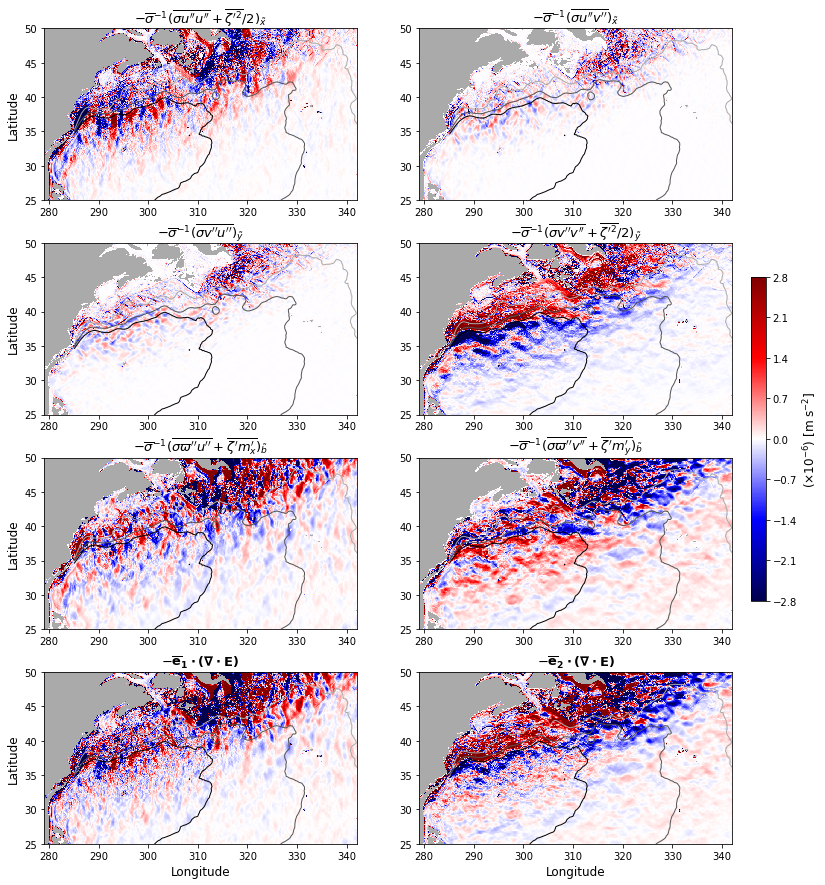

In [29]:
fig, axes = plt.subplots(figsize=(13,15), nrows=4, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(e00_x.XC, e00_x.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                          -e00_x.sel(YC=slice(ySstart+5-12**-1,
                                              yend+12**-1)).isel(time=0,delta_outer=nsig)*1e6, 
                          vmax=2.8e0, vmin=-2.8e0,
                          cmap='seismic', rasterized=True)
axes[1,0].pcolormesh(e10_y.XC, e10_y.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -e10_y.sel(YC=slice(ySstart+5-12**-1,
                                         yend+12**-1)).isel(time=0,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)
axes[0,1].pcolormesh(e01_x.XC, e01_x.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -e01_x.sel(YC=slice(ySstart+5-12**-1,
                                         yend+12**-1)).isel(time=0,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)
axes[1,1].pcolormesh(e11_y.XC, e11_y.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -e11_y.sel(YC=slice(ySstart+5-12**-1,
                                         yend+12**-1)).isel(time=0,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)
axes[2,0].pcolormesh(e20_b.XC, e20_b.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -e20_b.sel(YC=slice(ySstart+5-12**-1,
                                         yend+12**-1)).isel(time=0,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)
axes[2,1].pcolormesh(e21_b.XC, e21_b.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -e21_b.sel(YC=slice(ySstart+5-12**-1,
                                         yend+12**-1)).isel(time=0,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)
axes[3,0].pcolormesh(e00_x.XC, e00_x.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -Eu.sel(YC=slice(ySstart+5-12**-1,
                                      yend+12**-1)).isel(time=0,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)
axes[3,1].pcolormesh(e01_x.XC, e01_x.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -Ev.sel(YC=slice(ySstart+5-12**-1,
                                      yend+12**-1)).isel(time=0,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)


cs00 = axes[0,0].contour(zetab.XC.sel(XC=slice(285,None)), zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)).isel(time=0,delta_outer=nsig), 
                         levels=np.linspace(100,400,4), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs00.collections:
    c.set_rasterized(True)
cs01 = axes[0,1].contour(zetab.XC.sel(XC=slice(285,None)), zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)).isel(time=0,delta_outer=nsig), 
                         levels=np.linspace(100,400,4), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs01.collections:
    c.set_rasterized(True)
cs10 = axes[1,0].contour(zetab.XC.sel(XC=slice(285,None)), zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)).isel(time=0,delta_outer=nsig), 
                         levels=np.linspace(100,400,4),
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs10.collections:
    c.set_rasterized(True)
cs11 = axes[1,1].contour(zetab.XC.sel(XC=slice(285,None)), zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)).isel(time=0,delta_outer=nsig), 
                         levels=np.linspace(100,400,4), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs11.collections:
    c.set_rasterized(True)
cs20 = axes[2,0].contour(zetab.XC.sel(XC=slice(285,None)), zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)).isel(time=0,delta_outer=nsig), 
                         levels=np.linspace(100,400,4), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs20.collections:
    c.set_rasterized(True)
cs21 = axes[2,1].contour(zetab.XC.sel(XC=slice(285,None)), zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)).isel(time=0,delta_outer=nsig), 
                         levels=np.linspace(100,400,4),
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs21.collections:
    c.set_rasterized(True)
cs30 = axes[3,0].contour(zetab.XC.sel(XC=slice(285,None)), zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)).isel(time=0,delta_outer=nsig), 
                         levels=np.linspace(100,400,4), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs30.collections:
    c.set_rasterized(True)
cs31 = axes[3,1].contour(zetab.XC.sel(XC=slice(285,None)), zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)).isel(time=0,delta_outer=nsig), 
                         levels=np.linspace(100,400,4), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs31.collections:
    c.set_rasterized(True)
    

axes[0,0].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask0, ~mask0),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask0, ~mask0),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask0, ~mask0), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask0, ~mask0),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,0].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask0, ~mask0), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,1].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask0, ~mask0),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[3,0].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask0, ~mask0), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[3,1].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask0, ~mask0),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)


axes[0,0].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma u''u''} + \overline{\zeta'^2}/2)_\tilde{x}$", 
                    fontsize=13)
axes[1,0].set_title(r"$-\overline{\sigma}^{-1}(\overline{\sigma v''u''})_\tilde{y}$", 
                    fontsize=13)
axes[0,1].set_title(r"$-\overline{\sigma}^{-1}(\overline{\sigma u''v''})_\tilde{x}$", 
                    fontsize=13)
axes[1,1].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma v''v''} + \overline{\zeta'^2}/2)_\tilde{y}$", 
                    fontsize=13)
axes[2,0].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma \varpi''u''} + \overline{\zeta'm_x'})_\tilde{b}$", 
                    fontsize=13)
axes[2,1].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma \varpi''v''} + \overline{\zeta'm_y'})_\tilde{b}$", 
                    fontsize=13)
axes[3,0].set_title(r"$-\overline{\bf e}_1\cdot(\nabla\cdot{\bf E})$", fontsize=13)
axes[3,1].set_title(r"$-\overline{\bf e}_2\cdot(\nabla\cdot{\bf E})$", fontsize=13)

axes[3,0].set_xlabel(r"Longitude", fontsize=12)
axes[3,1].set_xlabel(r"Longitude", fontsize=12)
axes[0,0].set_ylabel(r"Latitude", fontsize=12)
axes[1,0].set_ylabel(r"Latitude", fontsize=12)
axes[2,0].set_ylabel(r"Latitude", fontsize=12)
axes[3,0].set_ylabel(r"Latitude", fontsize=12)

axes[0,0].set_ylim([25,50])
axes[0,1].set_ylim([25,50])
axes[1,0].set_ylim([25,50])
axes[1,1].set_ylim([25,50])
axes[2,0].set_ylim([25,50])
axes[2,1].set_ylim([25,50])
axes[3,0].set_ylim([25,50])
axes[3,1].set_ylim([25,50])
axes[0,0].set_xlim([279,342])
axes[0,1].set_xlim([279,342])
axes[1,0].set_xlim([279,342])
axes[1,1].set_xlim([279,342])
axes[2,0].set_xlim([279,342])
axes[2,1].set_xlim([279,342])
axes[3,0].set_xlim([279,342])
axes[3,1].set_xlim([279,342])

fig.subplots_adjust(right=0.86, hspace=.25)
cbaxes = fig.add_axes([0.88, 0.35, 0.016, 0.3]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes,
                    ticks=[-2.8,-2.1,-1.4,-.7,0.,.7,1.4,2.1,2.8])
# cbar.set_powerlimits(-1,1)
cbar.set_label(r"$(\times 10^{-6})$ [m s$^{-2}$]", fontsize=12)

plt.savefig(op.join(savedir,'Figures/DivE-P_flux_5Dave-delta_isig%02d_CLIM-Jan-03.pdf' % nsig))

/tank/tdgs/tuchida/envs/sep2021/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/tank/tdgs/tuchida/envs/sep2021/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/tank/

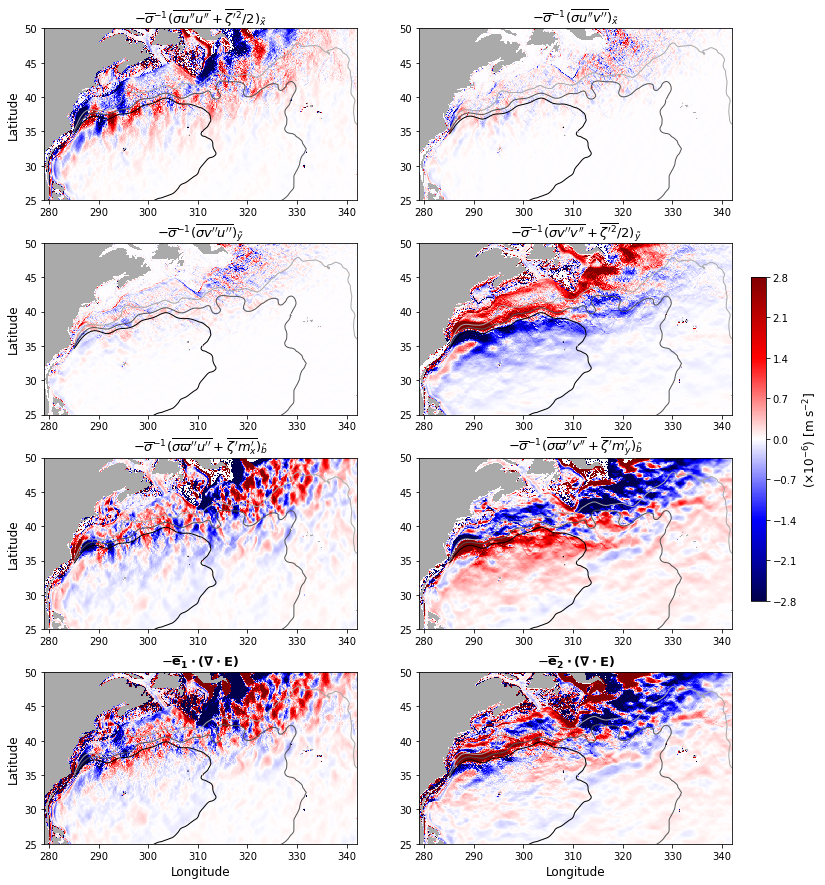

In [18]:
fig, axes = plt.subplots(figsize=(13,15), nrows=4, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(e00_x.XC, e00_x.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                          -e00_x.sel(YC=slice(ySstart+5-12**-1,
                                              yend+12**-1)
                                    ).groupby('seas').mean('time').isel(seas=0,delta_outer=nsig)*1e6, 
                          vmax=2.8e0, vmin=-2.8e0,
                          cmap='seismic', rasterized=True)
axes[1,0].pcolormesh(e10_y.XC, e10_y.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -e10_y.sel(YC=slice(ySstart+5-12**-1,
                                         yend+12**-1)
                               ).groupby('seas').mean('time').isel(seas=0,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)
axes[0,1].pcolormesh(e01_x.XC, e01_x.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -e01_x.sel(YC=slice(ySstart+5-12**-1,
                                         yend+12**-1)
                               ).groupby('seas').mean('time').isel(seas=0,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)
axes[1,1].pcolormesh(e11_y.XC, e11_y.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -e11_y.sel(YC=slice(ySstart+5-12**-1,
                                         yend+12**-1)
                               ).groupby('seas').mean('time').isel(seas=0,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)
axes[2,0].pcolormesh(e20_b.XC, e20_b.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -e20_b.sel(YC=slice(ySstart+5-12**-1,
                                         yend+12**-1)
                               ).groupby('seas').mean('time').isel(seas=0,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)
axes[2,1].pcolormesh(e21_b.XC, e21_b.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -e21_b.sel(YC=slice(ySstart+5-12**-1,
                                         yend+12**-1)
                               ).groupby('seas').mean('time').isel(seas=0,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)
axes[3,0].pcolormesh(e00_x.XC, e00_x.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -Eu.sel(YC=slice(ySstart+5-12**-1,
                                      yend+12**-1)
                            ).groupby('seas').mean('time').isel(seas=0,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)
axes[3,1].pcolormesh(e01_x.XC, e01_x.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -Ev.sel(YC=slice(ySstart+5-12**-1,
                                      yend+12**-1)
                            ).groupby('seas').mean('time').isel(seas=0,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)


cs00 = axes[0,0].contour(zetab.XC.sel(XC=slice(285,None)), 
                         zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)
                                                      ).groupby('seas').mean('time').isel(seas=0,delta_outer=nsig), 
                         levels=np.linspace(100,400,4), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs00.collections:
    c.set_rasterized(True)
cs01 = axes[0,1].contour(zetab.XC.sel(XC=slice(285,None)), 
                         zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)
                                                      ).groupby('seas').mean('time').isel(seas=0,delta_outer=nsig), 
                         levels=np.linspace(100,400,4), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs01.collections:
    c.set_rasterized(True)
cs10 = axes[1,0].contour(zetab.XC.sel(XC=slice(285,None)), 
                         zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)
                                                      ).groupby('seas').mean('time').isel(seas=0,delta_outer=nsig), 
                         levels=np.linspace(100,400,4),
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs10.collections:
    c.set_rasterized(True)
cs11 = axes[1,1].contour(zetab.XC.sel(XC=slice(285,None)), 
                         zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)
                                                      ).groupby('seas').mean('time').isel(seas=0,delta_outer=nsig), 
                         levels=np.linspace(100,400,4), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs11.collections:
    c.set_rasterized(True)
cs20 = axes[2,0].contour(zetab.XC.sel(XC=slice(285,None)), 
                         zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)
                                                      ).groupby('seas').mean('time').isel(seas=0,delta_outer=nsig), 
                         levels=np.linspace(100,400,4), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs20.collections:
    c.set_rasterized(True)
cs21 = axes[2,1].contour(zetab.XC.sel(XC=slice(285,None)), 
                         zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)
                                                      ).groupby('seas').mean('time').isel(seas=0,delta_outer=nsig), 
                         levels=np.linspace(100,400,4),
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs21.collections:
    c.set_rasterized(True)
cs30 = axes[3,0].contour(zetab.XC.sel(XC=slice(285,None)), 
                         zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)
                                                      ).groupby('seas').mean('time').isel(seas=0,delta_outer=nsig), 
                         levels=np.linspace(100,400,4), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs30.collections:
    c.set_rasterized(True)
cs31 = axes[3,1].contour(zetab.XC.sel(XC=slice(285,None)), 
                         zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)
                                                      ).groupby('seas').mean('time').isel(seas=0,delta_outer=nsig), 
                         levels=np.linspace(100,400,4), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs31.collections:
    c.set_rasterized(True)
    

axes[0,0].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask0, ~mask0),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask0, ~mask0),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask0, ~mask0), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask0, ~mask0),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,0].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask0, ~mask0), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,1].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask0, ~mask0),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[3,0].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask0, ~mask0), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[3,1].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask0, ~mask0),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)


axes[0,0].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma u''u''} + \overline{\zeta'^2}/2)_\tilde{x}$", 
                    fontsize=13)
axes[1,0].set_title(r"$-\overline{\sigma}^{-1}(\overline{\sigma v''u''})_\tilde{y}$", 
                    fontsize=13)
axes[0,1].set_title(r"$-\overline{\sigma}^{-1}(\overline{\sigma u''v''})_\tilde{x}$", 
                    fontsize=13)
axes[1,1].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma v''v''} + \overline{\zeta'^2}/2)_\tilde{y}$", 
                    fontsize=13)
axes[2,0].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma \varpi''u''} + \overline{\zeta'm_x'})_\tilde{b}$", 
                    fontsize=13)
axes[2,1].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma \varpi''v''} + \overline{\zeta'm_y'})_\tilde{b}$", 
                    fontsize=13)
axes[3,0].set_title(r"$-\overline{\bf e}_1\cdot(\nabla\cdot{\bf E})$", fontsize=13)
axes[3,1].set_title(r"$-\overline{\bf e}_2\cdot(\nabla\cdot{\bf E})$", fontsize=13)

axes[3,0].set_xlabel(r"Longitude", fontsize=12)
axes[3,1].set_xlabel(r"Longitude", fontsize=12)
axes[0,0].set_ylabel(r"Latitude", fontsize=12)
axes[1,0].set_ylabel(r"Latitude", fontsize=12)
axes[2,0].set_ylabel(r"Latitude", fontsize=12)
axes[3,0].set_ylabel(r"Latitude", fontsize=12)

axes[0,0].set_ylim([25,50])
axes[0,1].set_ylim([25,50])
axes[1,0].set_ylim([25,50])
axes[1,1].set_ylim([25,50])
axes[2,0].set_ylim([25,50])
axes[2,1].set_ylim([25,50])
axes[3,0].set_ylim([25,50])
axes[3,1].set_ylim([25,50])
axes[0,0].set_xlim([279,342])
axes[0,1].set_xlim([279,342])
axes[1,0].set_xlim([279,342])
axes[1,1].set_xlim([279,342])
axes[2,0].set_xlim([279,342])
axes[2,1].set_xlim([279,342])
axes[3,0].set_xlim([279,342])
axes[3,1].set_xlim([279,342])

fig.subplots_adjust(right=0.86, hspace=.25)
cbaxes = fig.add_axes([0.88, 0.35, 0.016, 0.3]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes,
                    ticks=[-2.8,-2.1,-1.4,-.7,0.,.7,1.4,2.1,2.8])
# cbar.set_powerlimits(-1,1)
cbar.set_label(r"$(\times 10^{-6})$ [m s$^{-2}$]", fontsize=12)

plt.savefig(op.join(savedir,'Figures/DivE-P_flux_5Dave-delta_isig%02d_CLIM-JFM.pdf' % nsig))

In [19]:
mask2 = np.ma.masked_invalid(dzetab.where(dzetab!=0.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1)
                                             ).groupby('seas').mean('time').isel(seas=2,delta_outer=nsig)
                            ).mask

/tank/tdgs/tuchida/envs/sep2021/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/tank/tdgs/tuchida/envs/sep2021/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/tank/

/tank/tdgs/tuchida/envs/sep2021/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/tank/tdgs/tuchida/envs/sep2021/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/tank/

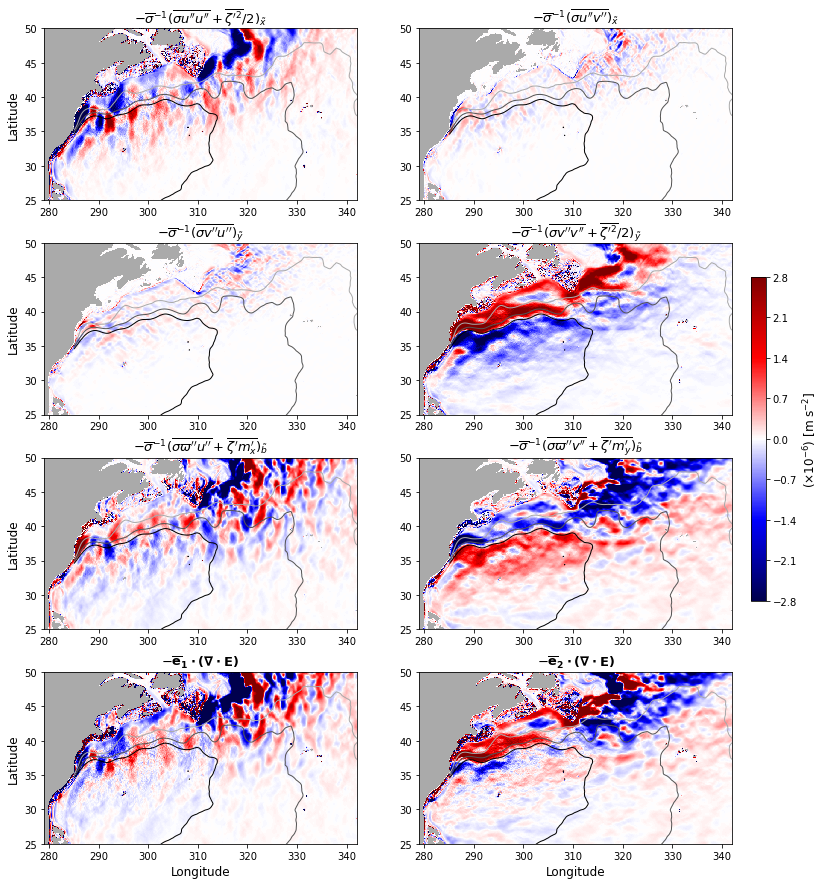

In [20]:
fig, axes = plt.subplots(figsize=(13,15), nrows=4, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(e00_x.XC, e00_x.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                          -e00_x.sel(YC=slice(ySstart+5-12**-1,
                                              yend+12**-1)
                                    ).groupby('seas').mean('time').isel(seas=2,delta_outer=nsig)*1e6, 
                          vmax=2.8e0, vmin=-2.8e0,
                          cmap='seismic', rasterized=True)
axes[1,0].pcolormesh(e10_y.XC, e10_y.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -e10_y.sel(YC=slice(ySstart+5-12**-1,
                                         yend+12**-1)
                               ).groupby('seas').mean('time').isel(seas=2,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)
axes[0,1].pcolormesh(e01_x.XC, e01_x.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -e01_x.sel(YC=slice(ySstart+5-12**-1,
                                         yend+12**-1)
                               ).groupby('seas').mean('time').isel(seas=2,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)
axes[1,1].pcolormesh(e11_y.XC, e11_y.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -e11_y.sel(YC=slice(ySstart+5-12**-1,
                                         yend+12**-1)
                               ).groupby('seas').mean('time').isel(seas=2,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)
axes[2,0].pcolormesh(e20_b.XC, e20_b.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -e20_b.sel(YC=slice(ySstart+5-12**-1,
                                         yend+12**-1)
                               ).groupby('seas').mean('time').isel(seas=2,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)
axes[2,1].pcolormesh(e21_b.XC, e21_b.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -e21_b.sel(YC=slice(ySstart+5-12**-1,
                                         yend+12**-1)
                               ).groupby('seas').mean('time').isel(seas=2,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)
axes[3,0].pcolormesh(e00_x.XC, e00_x.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -Eu.sel(YC=slice(ySstart+5-12**-1,
                                      yend+12**-1)
                            ).groupby('seas').mean('time').isel(seas=2,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)
axes[3,1].pcolormesh(e01_x.XC, e01_x.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -Ev.sel(YC=slice(ySstart+5-12**-1,
                                      yend+12**-1)
                            ).groupby('seas').mean('time').isel(seas=2,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)


cs00 = axes[0,0].contour(zetab.XC.sel(XC=slice(285,None)), 
                         zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)
                                                      ).groupby('seas').mean('time').isel(seas=2,delta_outer=nsig), 
                         levels=np.linspace(100,400,4), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs00.collections:
    c.set_rasterized(True)
cs01 = axes[0,1].contour(zetab.XC.sel(XC=slice(285,None)), 
                         zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)
                                                      ).groupby('seas').mean('time').isel(seas=2,delta_outer=nsig), 
                         levels=np.linspace(100,400,4), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs01.collections:
    c.set_rasterized(True)
cs10 = axes[1,0].contour(zetab.XC.sel(XC=slice(285,None)), 
                         zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)
                                                      ).groupby('seas').mean('time').isel(seas=2,delta_outer=nsig), 
                         levels=np.linspace(100,400,4),
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs10.collections:
    c.set_rasterized(True)
cs11 = axes[1,1].contour(zetab.XC.sel(XC=slice(285,None)), 
                         zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)
                                                      ).groupby('seas').mean('time').isel(seas=2,delta_outer=nsig), 
                         levels=np.linspace(100,400,4), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs11.collections:
    c.set_rasterized(True)
cs20 = axes[2,0].contour(zetab.XC.sel(XC=slice(285,None)), 
                         zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)
                                                      ).groupby('seas').mean('time').isel(seas=2,delta_outer=nsig), 
                         levels=np.linspace(100,400,4), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs20.collections:
    c.set_rasterized(True)
cs21 = axes[2,1].contour(zetab.XC.sel(XC=slice(285,None)), 
                         zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)
                                                      ).groupby('seas').mean('time').isel(seas=2,delta_outer=nsig), 
                         levels=np.linspace(100,400,4),
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs21.collections:
    c.set_rasterized(True)
cs30 = axes[3,0].contour(zetab.XC.sel(XC=slice(285,None)), 
                         zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)
                                                      ).groupby('seas').mean('time').isel(seas=2,delta_outer=nsig), 
                         levels=np.linspace(100,400,4), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs30.collections:
    c.set_rasterized(True)
cs31 = axes[3,1].contour(zetab.XC.sel(XC=slice(285,None)), 
                         zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)
                                                      ).groupby('seas').mean('time').isel(seas=2,delta_outer=nsig), 
                         levels=np.linspace(100,400,4), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs31.collections:
    c.set_rasterized(True)
    

axes[0,0].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask2, ~mask2),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask2, ~mask2),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask2, ~mask2), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask2, ~mask2),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,0].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask2, ~mask2), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,1].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask2, ~mask2),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[3,0].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask2, ~mask2), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[3,1].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask2, ~mask2),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)


axes[0,0].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma u''u''} + \overline{\zeta'^2}/2)_\tilde{x}$", 
                    fontsize=13)
axes[1,0].set_title(r"$-\overline{\sigma}^{-1}(\overline{\sigma v''u''})_\tilde{y}$", 
                    fontsize=13)
axes[0,1].set_title(r"$-\overline{\sigma}^{-1}(\overline{\sigma u''v''})_\tilde{x}$", 
                    fontsize=13)
axes[1,1].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma v''v''} + \overline{\zeta'^2}/2)_\tilde{y}$", 
                    fontsize=13)
axes[2,0].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma \varpi''u''} + \overline{\zeta'm_x'})_\tilde{b}$", 
                    fontsize=13)
axes[2,1].set_title(r"$-\overline{\sigma}^{-1}($"
                    + r"$\overline{\sigma \varpi''v''} + \overline{\zeta'm_y'})_\tilde{b}$", 
                    fontsize=13)
axes[3,0].set_title(r"$-\overline{\bf e}_1\cdot(\nabla\cdot{\bf E})$", fontsize=13)
axes[3,1].set_title(r"$-\overline{\bf e}_2\cdot(\nabla\cdot{\bf E})$", fontsize=13)

axes[3,0].set_xlabel(r"Longitude", fontsize=12)
axes[3,1].set_xlabel(r"Longitude", fontsize=12)
axes[0,0].set_ylabel(r"Latitude", fontsize=12)
axes[1,0].set_ylabel(r"Latitude", fontsize=12)
axes[2,0].set_ylabel(r"Latitude", fontsize=12)
axes[3,0].set_ylabel(r"Latitude", fontsize=12)

axes[0,0].set_ylim([25,50])
axes[0,1].set_ylim([25,50])
axes[1,0].set_ylim([25,50])
axes[1,1].set_ylim([25,50])
axes[2,0].set_ylim([25,50])
axes[2,1].set_ylim([25,50])
axes[3,0].set_ylim([25,50])
axes[3,1].set_ylim([25,50])
axes[0,0].set_xlim([279,342])
axes[0,1].set_xlim([279,342])
axes[1,0].set_xlim([279,342])
axes[1,1].set_xlim([279,342])
axes[2,0].set_xlim([279,342])
axes[2,1].set_xlim([279,342])
axes[3,0].set_xlim([279,342])
axes[3,1].set_xlim([279,342])

fig.subplots_adjust(right=0.86, hspace=.25)
cbaxes = fig.add_axes([0.88, 0.35, 0.016, 0.3]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes,
                    ticks=[-2.8,-2.1,-1.4,-.7,0.,.7,1.4,2.1,2.8])
# cbar.set_powerlimits(-1,1)
cbar.set_label(r"$(\times 10^{-6})$ [m s$^{-2}$]", fontsize=12)

plt.savefig(op.join(savedir,'Figures/DivE-P_flux_5Dave-delta_isig%02d_CLIM-JAS.pdf' % nsig))

/tank/tdgs/tuchida/envs/sep2021/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/tank/tdgs/tuchida/envs/sep2021/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/tank/

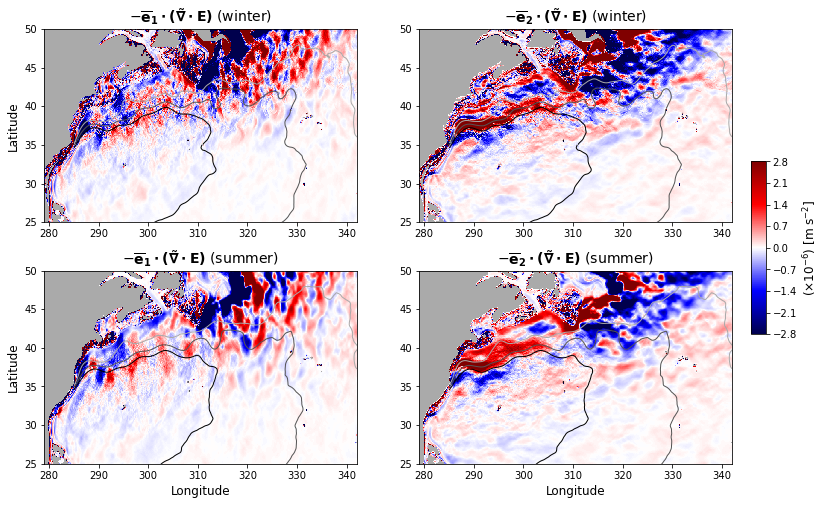

In [24]:
fig, axes = plt.subplots(figsize=(13,8), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(e00_x.XC, e00_x.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                          -Eu.sel(YC=slice(ySstart+5-12**-1,
                                           yend+12**-1)
                                 ).groupby('seas').mean('time').isel(seas=0,delta_outer=nsig)*1e6, 
                          vmax=2.8e0, vmin=-2.8e0,
                          cmap='seismic', rasterized=True)
axes[0,1].pcolormesh(e01_x.XC, e01_x.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -Ev.sel(YC=slice(ySstart+5-12**-1,
                                      yend+12**-1)
                            ).groupby('seas').mean('time').isel(seas=0,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)
axes[1,0].pcolormesh(e00_x.XC, e00_x.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -Eu.sel(YC=slice(ySstart+5-12**-1,
                                      yend+12**-1)
                            ).groupby('seas').mean('time').isel(seas=2,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)
axes[1,1].pcolormesh(e01_x.XC, e01_x.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     -Ev.sel(YC=slice(ySstart+5-12**-1,
                                      yend+12**-1)
                            ).groupby('seas').mean('time').isel(seas=2,delta_outer=nsig)*1e6, 
                     vmax=2.8e0, vmin=-2.8e0,
                     cmap='seismic', rasterized=True)


cs00 = axes[0,0].contour(zetab.XC.sel(XC=slice(285,None)), 
                         zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)
                                                      ).groupby('seas').mean('time').isel(seas=0,delta_outer=nsig), 
                         levels=np.linspace(100,400,4), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs00.collections:
    c.set_rasterized(True)
cs01 = axes[0,1].contour(zetab.XC.sel(XC=slice(285,None)), 
                         zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)
                                                      ).groupby('seas').mean('time').isel(seas=0,delta_outer=nsig), 
                         levels=np.linspace(100,400,4), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs01.collections:
    c.set_rasterized(True)
cs10 = axes[1,0].contour(zetab.XC.sel(XC=slice(285,None)), 
                         zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)
                                                      ).groupby('seas').mean('time').isel(seas=2,delta_outer=nsig), 
                         levels=np.linspace(100,400,4),
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs10.collections:
    c.set_rasterized(True)
cs11 = axes[1,1].contour(zetab.XC.sel(XC=slice(285,None)), 
                         zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)
                                                      ).groupby('seas').mean('time').isel(seas=2,delta_outer=nsig), 
                         levels=np.linspace(100,400,4), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs11.collections:
    c.set_rasterized(True)

    
axes[0,0].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask0, ~mask0),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask2, ~mask2),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask0, ~mask0), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(ds6.XC, ds6.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask2, ~mask2),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)


axes[0,0].set_title(r"$-\overline{\bf e}_1\cdot(\tilde{\nabla}\cdot{\bf E})$ (winter)", fontsize=14)
axes[0,1].set_title(r"$-\overline{\bf e}_2\cdot(\tilde{\nabla}\cdot{\bf E})$ (winter)", fontsize=14)
axes[1,0].set_title(r"$-\overline{\bf e}_1\cdot(\tilde{\nabla}\cdot{\bf E})$ (summer)", fontsize=14)
axes[1,1].set_title(r"$-\overline{\bf e}_2\cdot(\tilde{\nabla}\cdot{\bf E})$ (summer)", fontsize=14)

axes[1,0].set_xlabel(r"Longitude", fontsize=12)
axes[1,1].set_xlabel(r"Longitude", fontsize=12)
axes[0,0].set_ylabel(r"Latitude", fontsize=12)
axes[1,0].set_ylabel(r"Latitude", fontsize=12)

axes[0,0].set_ylim([25,50])
axes[0,1].set_ylim([25,50])
axes[1,0].set_ylim([25,50])
axes[1,1].set_ylim([25,50])

axes[0,0].set_xlim([279,342])
axes[0,1].set_xlim([279,342])
axes[1,0].set_xlim([279,342])
axes[1,1].set_xlim([279,342])


fig.subplots_adjust(right=0.86, hspace=.25)
cbaxes = fig.add_axes([0.88, 0.35, 0.016, 0.3]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes,
                    ticks=[-2.8,-2.1,-1.4,-.7,0.,.7,1.4,2.1,2.8])
# cbar.set_powerlimits(-1,1)
cbar.set_label(r"$(\times 10^{-6})$ [m s$^{-2}$]", fontsize=12)

plt.savefig(op.join(savedir,'Figures/DivE-P_flux_5Dave-delta_isig%02d_CLIM-seas.pdf' % nsig))

In [ ]:
client.close()